# Aim

This notebook contains a bit of data exploration regarding the Fluorescent Neuronal Cells collection, with some summary statistics reported in the paper.

### Imports

Imports and settings.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from itertools import product

from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

from skimage import io
from matplotlib import pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')


# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.2f}'.format

# Display all cell outputs
InteractiveShell.ast_node_interactivity = 'all'

ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
size = 14
params = {'legend.fontsize': 'large',
          'font.family': "Helvetica",
          'figure.figsize': (8, 8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': 11,
          'ytick.labelsize': 9,
          'legend.title_fontsize': 11,
          'legend.fontsize': 9
          # 'axes.titlepad': 25
          }
plt.rcParams.update(params)

plt.style.use('seaborn-whitegrid')
# alternative to the above
# plt.rcParams["axes.grid"] = True
# plt.rcParams["axes.grid.which"] = "both"
# plt.rcParams["axes.linewidth"] = 0.5
# plt.rcParams["grid.linestyle"] = "--"
# plt.rcParams["grid.alpha"] = 0.5

In [2]:
import sys

code_path = "../"
sys.path.append(code_path)
from fluocells.config import REPO_PATH, DATA_PATH, DATA_PATH_g, DATA_PATH_y, DATA_PATH_r, METADATA

# Visual Inspection

Let's first visualize some images and binary masks for each dataset.

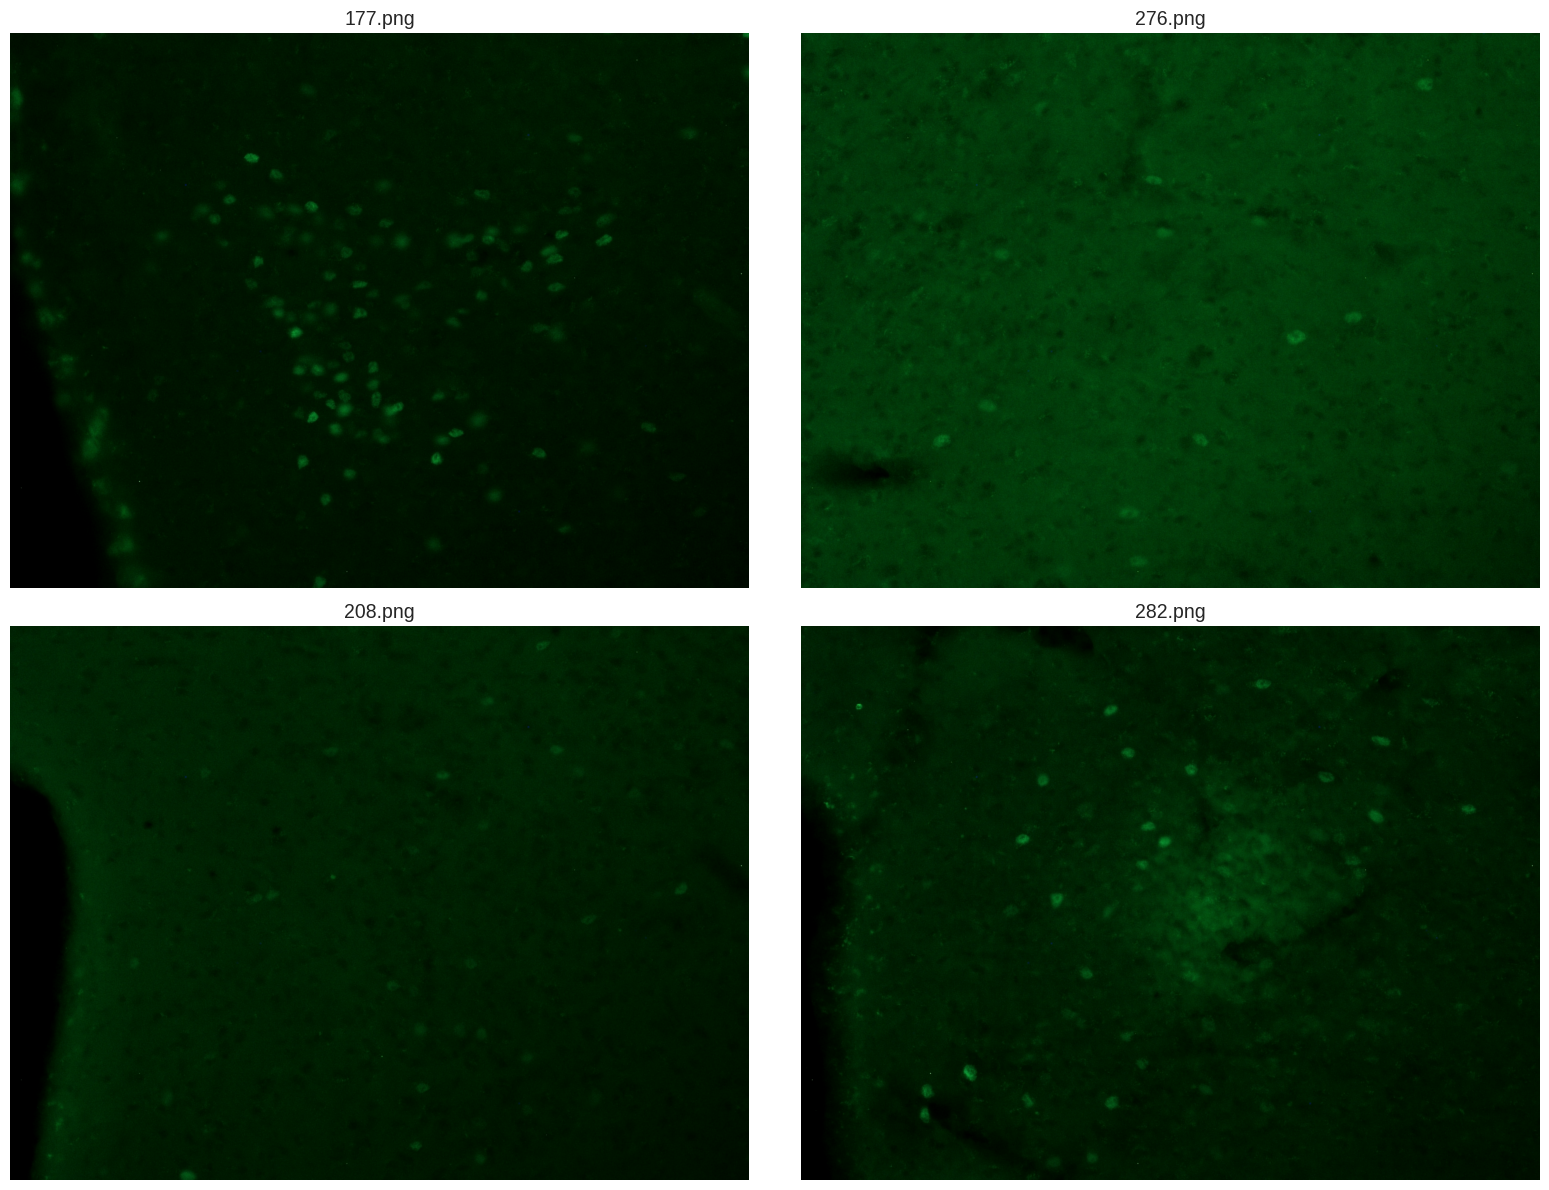

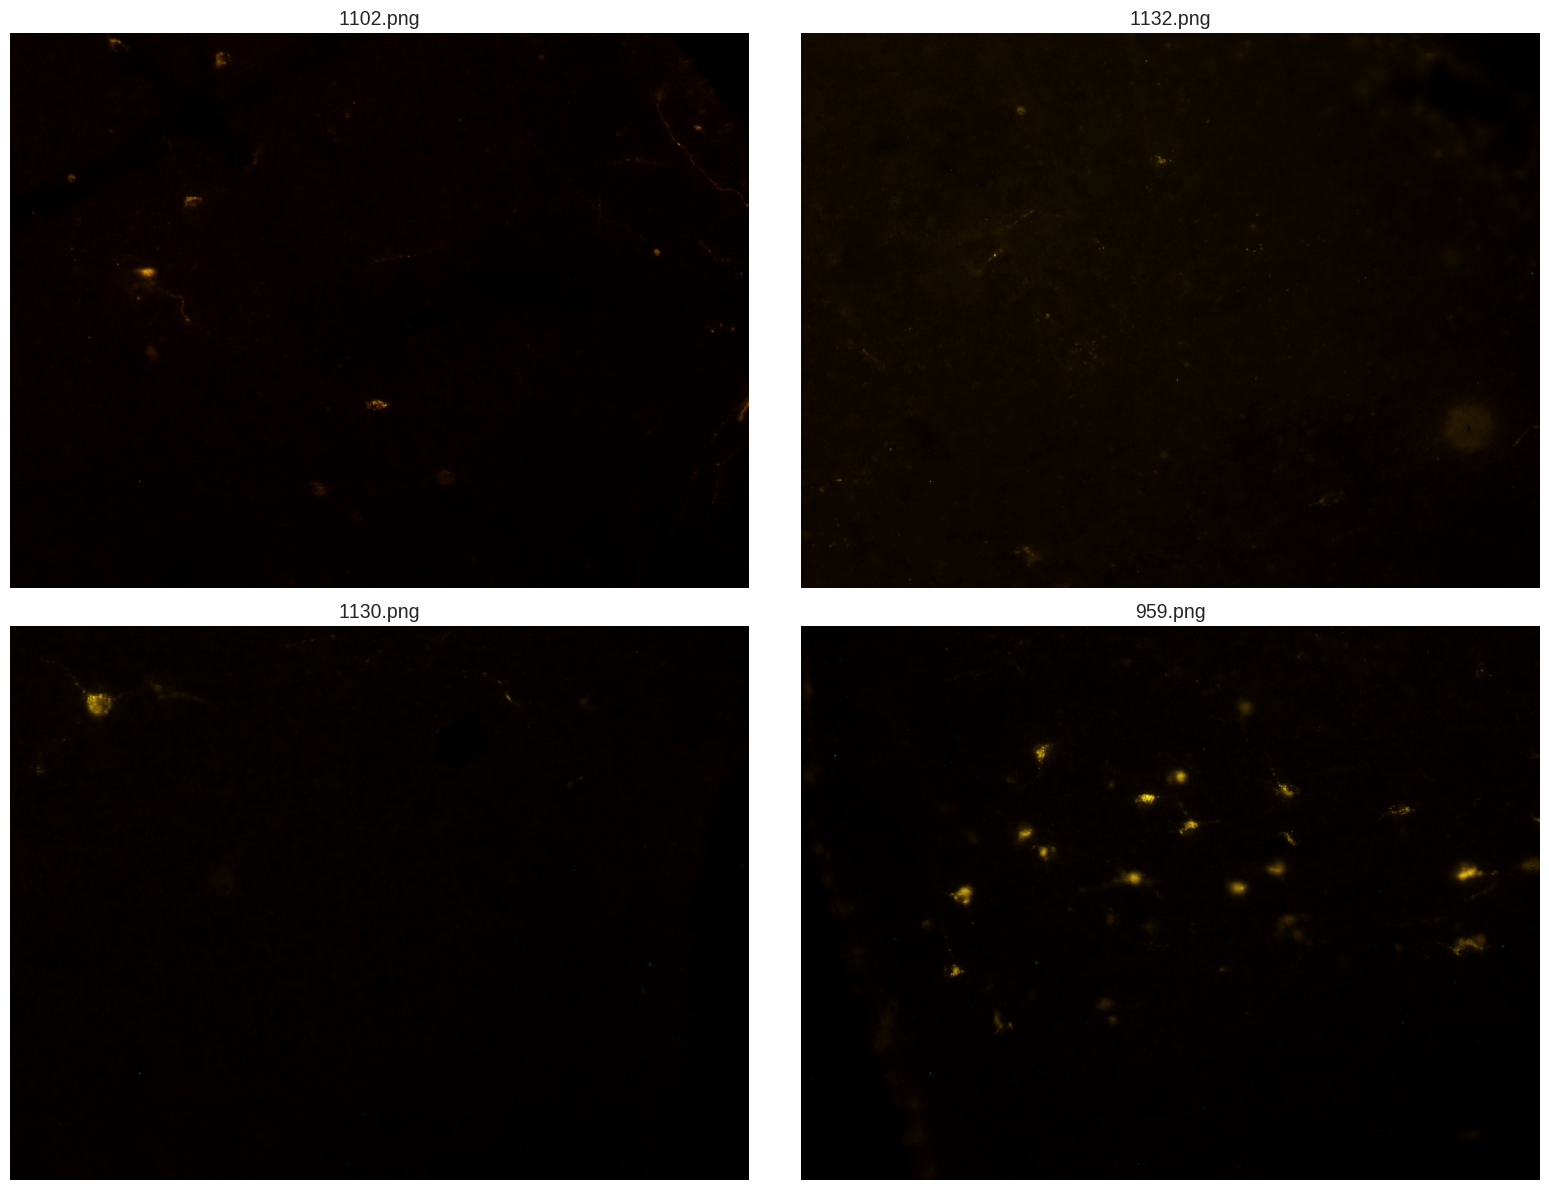

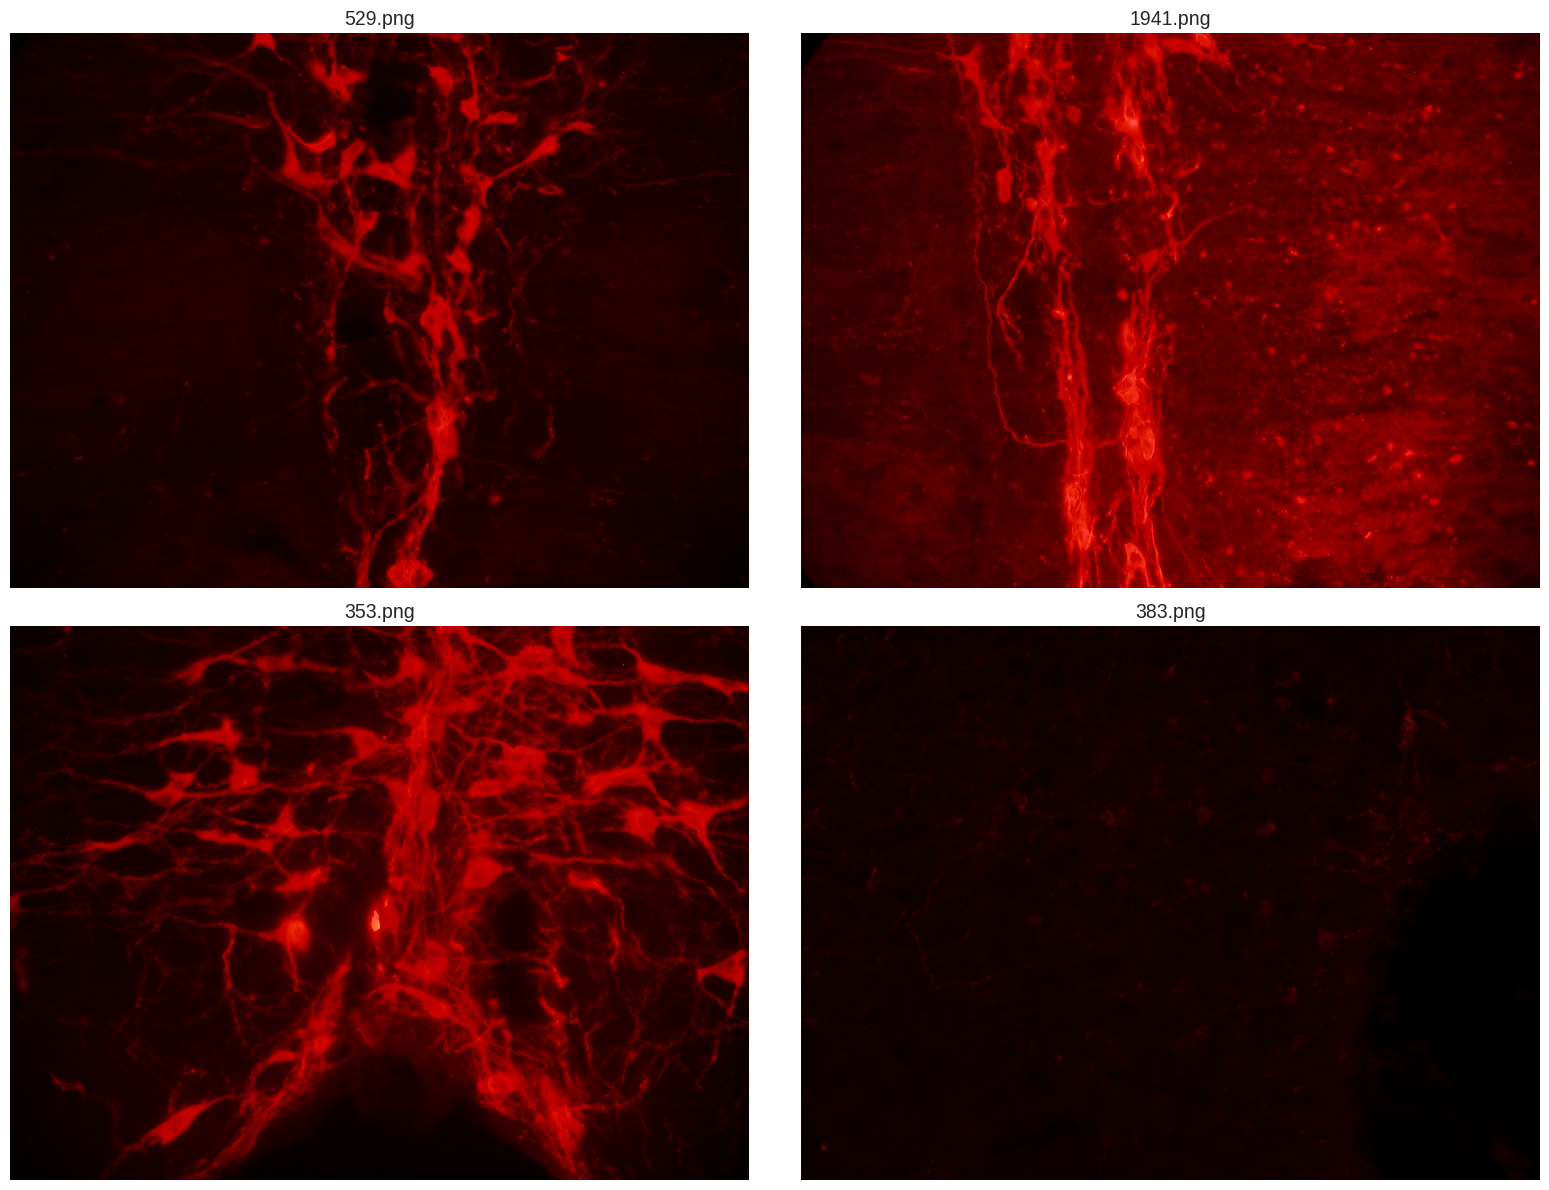

In [3]:
for dataset_path in [DATA_PATH_g, DATA_PATH_y, DATA_PATH_r]:
    sample_data_path = dataset_path / 'trainval' / 'images'
    fig = plt.figure(figsize=(16, 12))
    for i, img_path in enumerate([*sample_data_path.iterdir()][:4]):
        img = io.imread(img_path)
        sb = plt.subplot(2, 2, i + 1)
        plot = plt.title(img_path.name)
        plot = plt.axis('off')
        plot = plt.imshow(img)
    plt.tight_layout()
    plt.show()

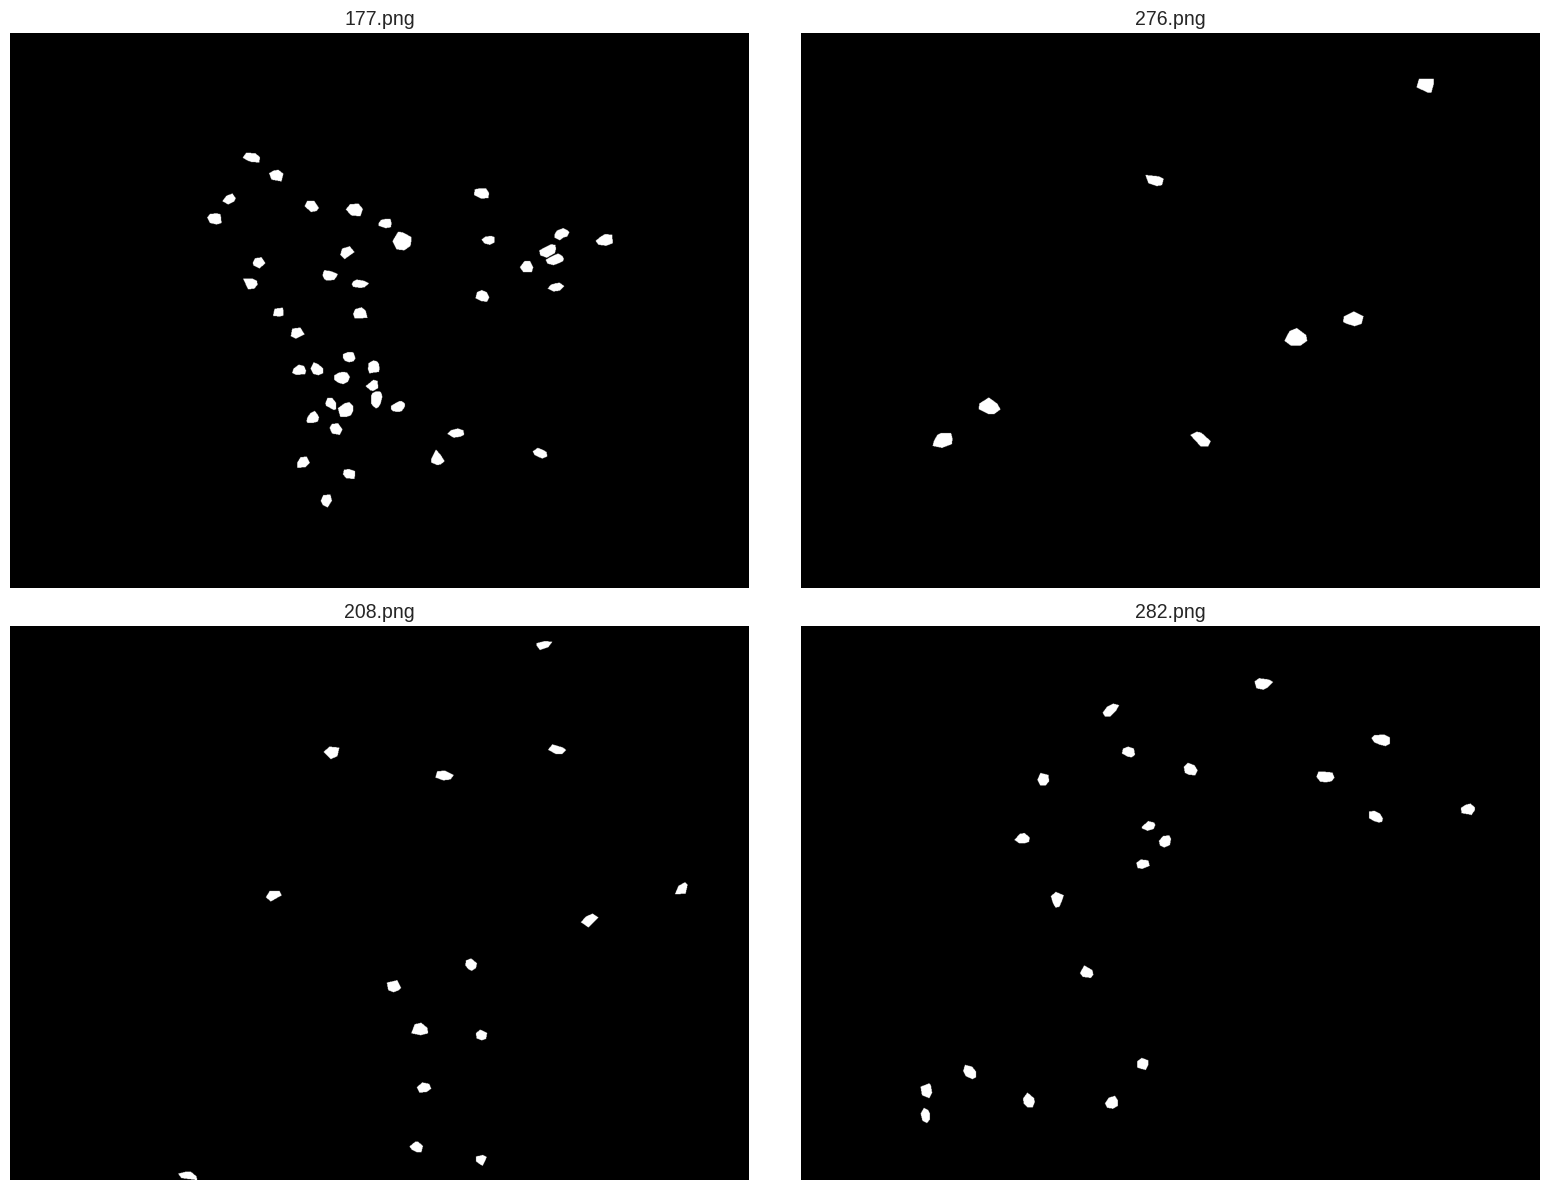

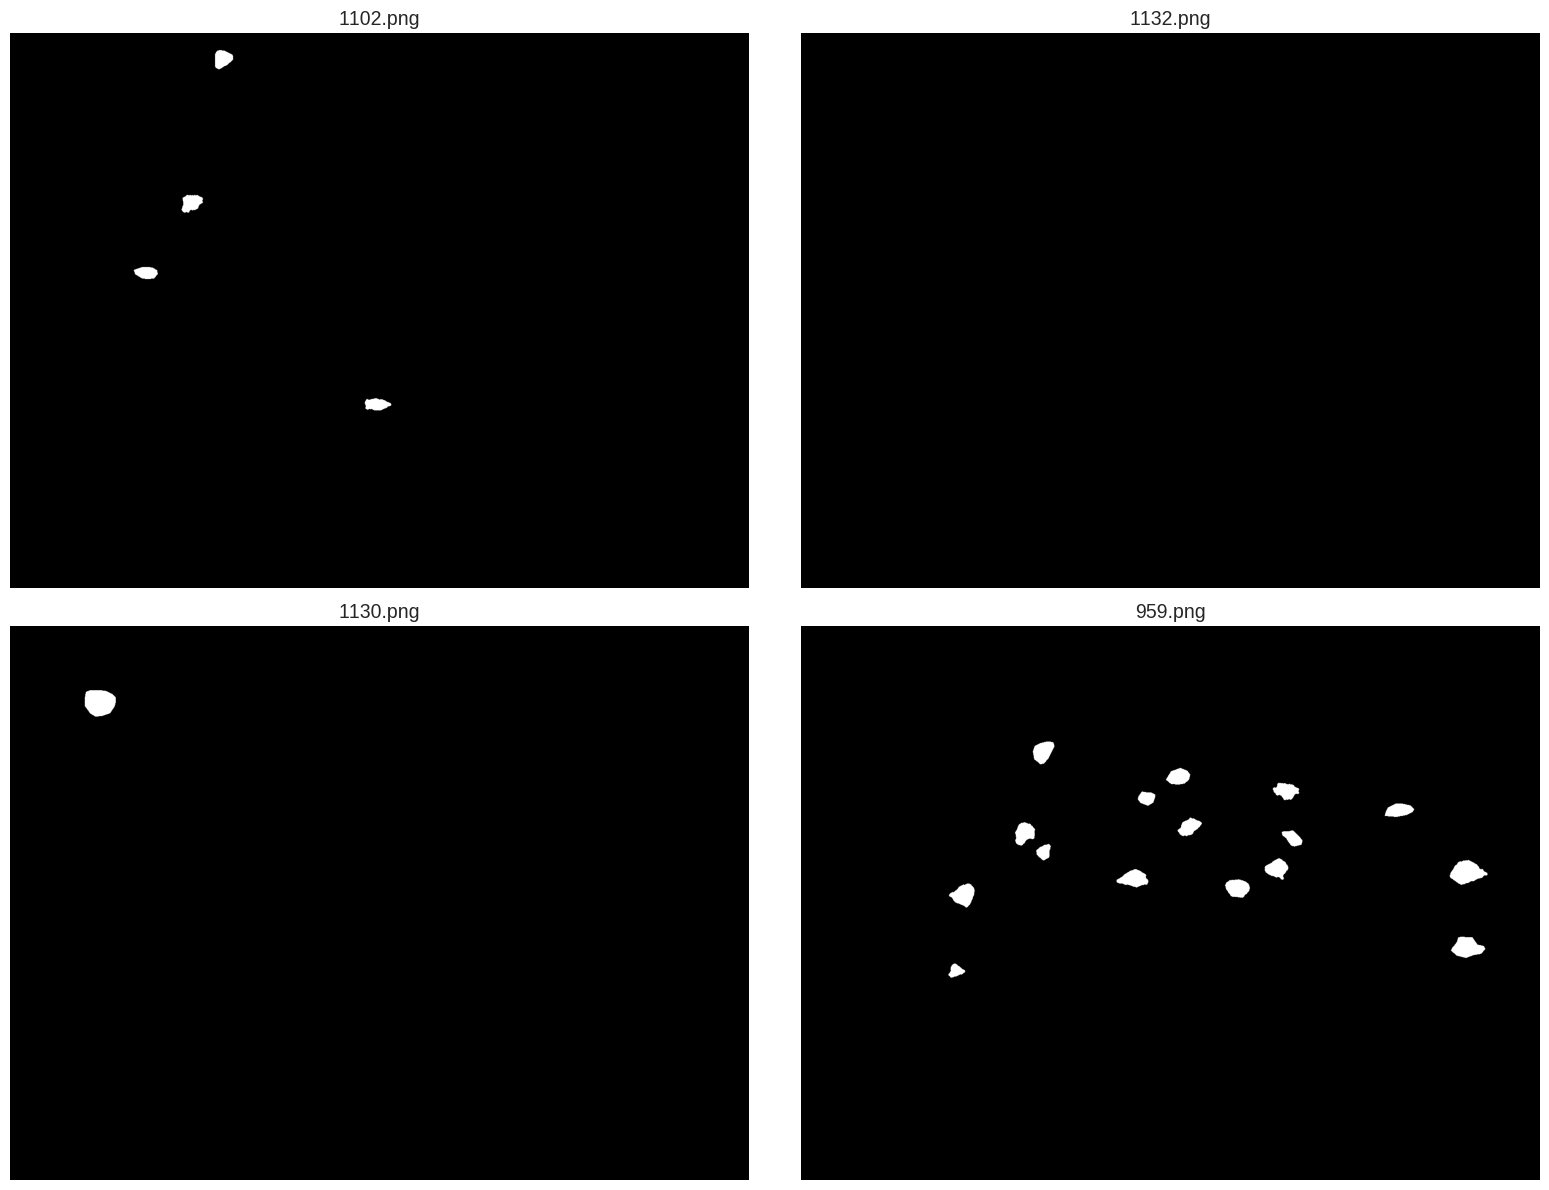

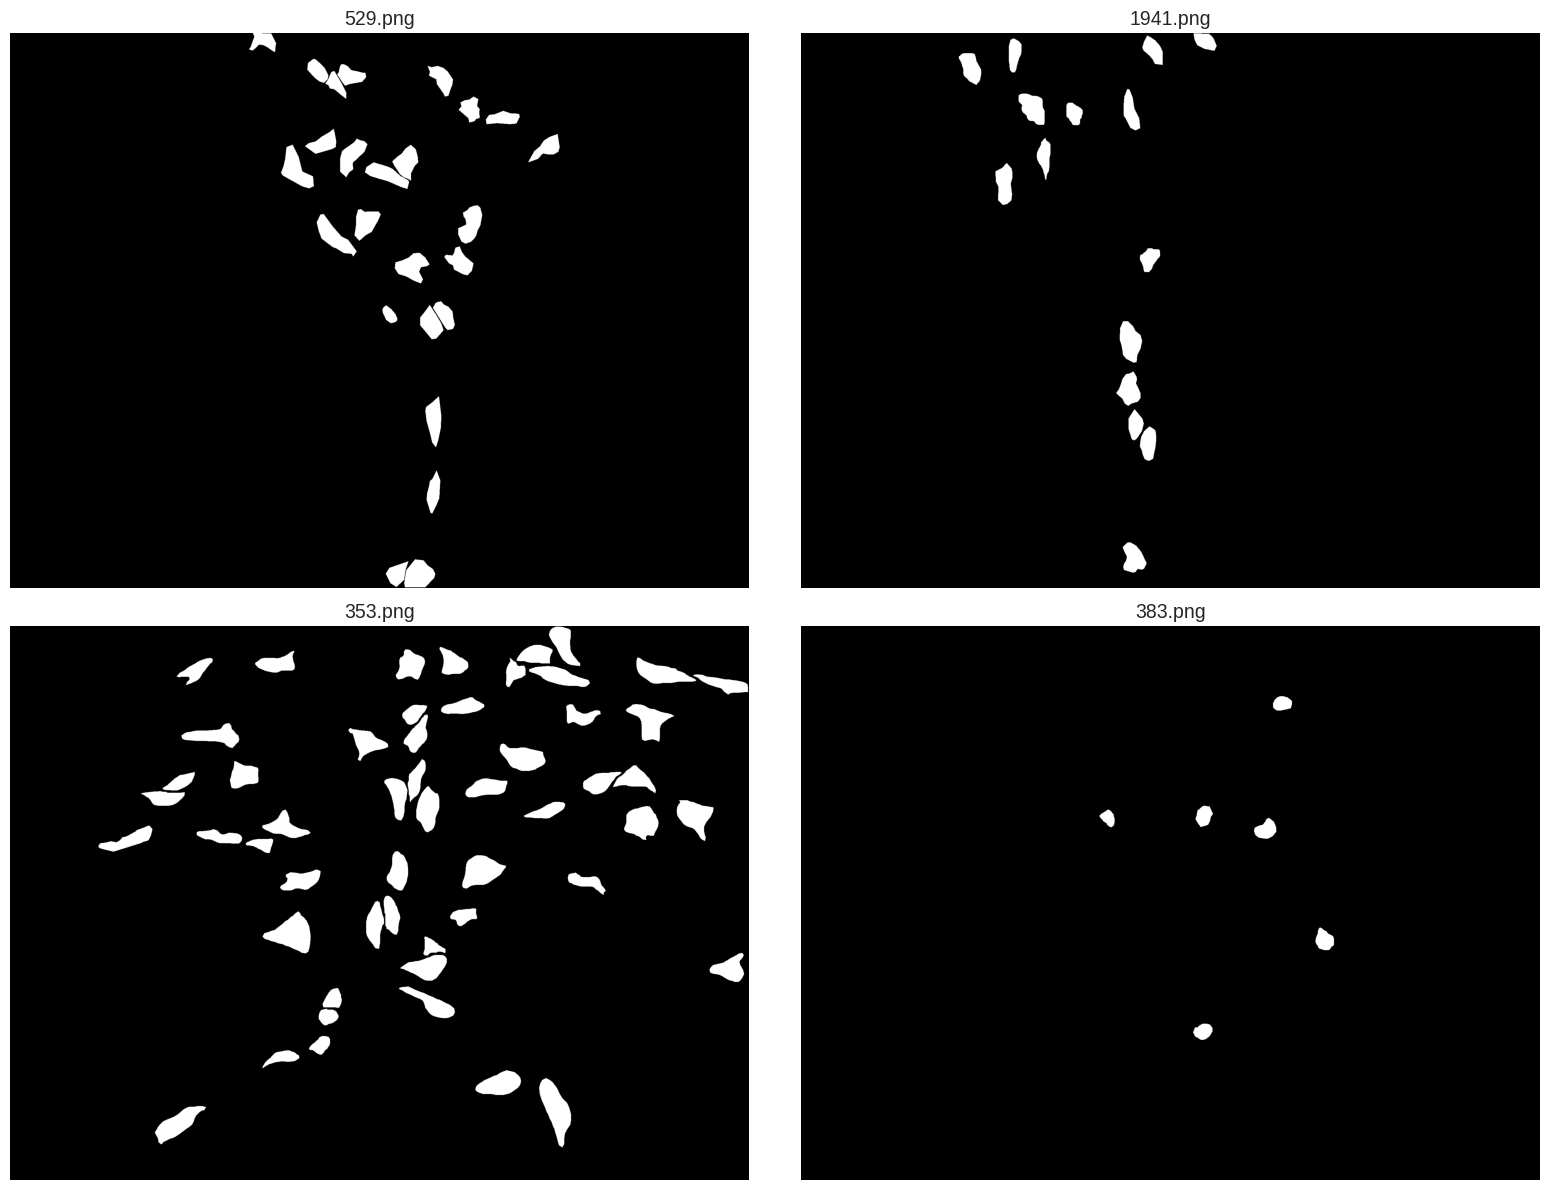

In [4]:
for dataset_path in [DATA_PATH_g, DATA_PATH_y, DATA_PATH_r]:
    sample_data_path = dataset_path / 'trainval' / 'ground_truths/masks'
    fig = plt.figure(figsize=(16, 12))
    for i, img_path in enumerate([*sample_data_path.iterdir()][:4]):
        img = io.imread(img_path, as_gray=True)
        sb = plt.subplot(2, 2, i + 1)
        plot = plt.title(img_path.name)
        plot = plt.axis('off')
        plot = plt.imshow(img, cmap="gray")
    plt.tight_layout()
    plt.show()

# Summary statistics

In [5]:
# read metadata
meta_df = pd.read_excel(DATA_PATH_y.parent /
                        f"metadata_{METADATA['current_version']}.xlsx",
                        sheet_name="metadata")

# Get summary stats and rearrange df for plotting
df_stats = meta_df.groupby(['dataset', 'partition'
                            ])['image_name'].size().reset_index(name='total')
df_stats

dataset   partition  total
0   green        test     70
1   green    trainval    213
2   green  unlabelled    408
3     red        test     46
4     red    trainval    138
5     red  unlabelled    362
6  yellow        test     70
7  yellow    trainval    213
8  yellow  unlabelled    354

## Data volumes

In [6]:
total_images = len(meta_df)
total_labelled = len(meta_df.query("partition != 'unlabelled'"))
total_unlabelled = len(meta_df.query("partition == 'unlabelled'"))

print(f"{total_images=}")
print(f"{total_labelled=}")
print(f"{total_unlabelled=}")

total_images=1874
total_labelled=750
total_unlabelled=1124


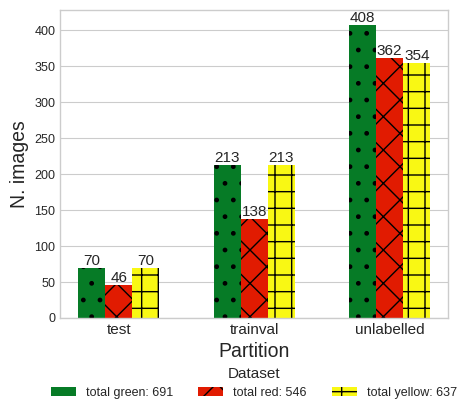

In [7]:
# labelling utils
datasets = ["green", "red", "yellow"]
sizes = df_stats.groupby("dataset")["total"].sum().values
colors = {"green": '#067b26', "red": '#e11b01', "yellow": '#f9f814'}
patterns = {"green": '.', "red": 'x', "yellow": '+'}
labels = [f"total {dataset}: {size}" for dataset, size in zip(datasets, sizes)]

# Plot
annotations_size = 11  #int(size*2/3)

width = 0.2
x = np.arange(len(df_stats['partition'].unique()))

fig, ax = plt.subplots(figsize=(5, 4))
colors = ['#067b26', '#e11b01', '#f9f814']
patterns = [".", "x", "+"]
h = 0
for i, (group, data) in enumerate(df_stats.groupby('dataset')):
    xs = x + (i - 1) * width
    _ = ax.bar(xs,
               data['total'],
               width=width,
               label=group,
               color=colors[i],
               hatch=patterns[i])
    for j, count in enumerate(data['total']):
        _ = ax.text(xs[j],
                    count,
                    str(count),
                    ha='center',
                    va='bottom',
                    size=annotations_size)

# Set custom x-axis tick labels
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(df_stats['partition'].unique())

# Set labels and title
_ = ax.set_xlabel('Partition')
_ = ax.set_ylabel('N. images')
# _ = ax.set_title('FNC collection composition')
_ = ax.legend(title='Dataset')

# Set layout for consistent outlook
_ = fig.patch.set_alpha(0)
_ = ax.patch.set_alpha(0)

# Move the legend outside and set custom labels
_ = ax.legend(title='Dataset',
              bbox_to_anchor=(0.5, -0.3),
              loc='lower center',
              ncol=len(df_stats['dataset'].unique()),
              fancybox=True,
              shadow=True,
              labels=labels,
#               title_fontsize=annotations_size,
#               fontsize=annotations_size - 2
             )
ax.xaxis.grid(False) 

# Save the plot as PDF
fig.savefig(REPO_PATH / "figures" / "FNC_composition.pdf", bbox_inches='tight')
plt.show()

## Dataset only statistics

This section refers to statistics only grouped by datset.

### Class imbalance

In [8]:
all_mask_paths = []
for dataset, partition in product(["green", "red", "yellow"],
                                  ["trainval", "test"]):
    all_mask_paths.extend(
        [*(DATA_PATH / dataset / partition / "ground_truths/masks").iterdir()])

signal_pct_df = pd.DataFrame()
for mask_path in tqdm(all_mask_paths):
    mask = io.imread(mask_path, as_gray=True)
    total_pixels = mask.shape[0] * mask.shape[1]

    partition = mask_path.parent.parent.parent.name
    dataset = mask_path.parent.parent.parent.parent.name

    # check binary masks
    if len(np.unique(mask)) > 2:
        print(mask_path.name)
        print(np.unique(mask))
        raise (NotImplementedError)

    # check masks are in [0, 255] format
    if mask.max() != 255 and 0:
        # mask = mask/mask.max()
        raise (NotImplementedError)

    ones = mask.astype('bool').sum()
    zeros = total_pixels - ones
    values, counts = [0, 1], [zeros, ones]

    image_signal_stats = pd.DataFrame(
        [[mask_path.name, dataset, partition, zeros, ones, total_pixels]],
        columns=[
            "image_name", "dataset", "partition", "zeros", "ones", "total"
        ])
    signal_pct_df = pd.concat([signal_pct_df, image_signal_stats], axis=0)

  0%|          | 0/750 [00:00<?, ?it/s]

In [9]:
eps = 1
qq = [0.1, 0.25, 0.5, 0.75, 0.9]

signal_pct_df[
    'class0_to_total'] = signal_pct_df["zeros"] / signal_pct_df["total"] * 100
signal_pct_df[
    'class1_to_total'] = signal_pct_df["ones"] / signal_pct_df["total"] * 100
# signal_pct_df['background_to_signal'] = signal_pct_df["zeros"]/(signal_pct_df["ones"]+eps)

signal_pct_df['zeros'] = signal_pct_df['zeros'].astype(int)
signal_pct_df['ones'] = signal_pct_df['ones'].astype(int)
signal_pct_df['total'] = signal_pct_df['total'].astype(int)
signal_pct_df['class0_to_total'] = signal_pct_df['class0_to_total'].astype(
    float)
signal_pct_df['class1_to_total'] = signal_pct_df['class1_to_total'].astype(
    float)

signal_pct_df.head()

image_name dataset partition    zeros   ones    total  class0_to_total  \
0    177.png   green  trainval  1896715  23285  1920000            98.79   
0    276.png   green  trainval  1913240   6760  1920000            99.65   
0    208.png   green  trainval  1912466   7534  1920000            99.61   
0    282.png   green  trainval  1908468  11532  1920000            99.40   
0    254.png   green  trainval  1901449  18551  1920000            99.03   

   class1_to_total  
0             1.21  
0             0.35  
0             0.39  
0             0.60  
0             0.97

In [10]:
def _create_multiindex_univariate(var):

    idx = pd.MultiIndex.from_tuples([
        ('variable', ''),
        (var, 'green'),
        (var, 'red'),
        (var, 'yellow'),
    ],
                                    names=['feature', 'dataset'])
    return idx


summary = signal_pct_df.groupby(["dataset"]).describe(percentiles=qq)

summary_table_univariate = summary.transpose().reset_index().set_index(
    'level_1')
summary_table_univariate = summary_table_univariate[
    summary_table_univariate.level_0 == "class1_to_total"]
summary_table_univariate.index.name = "statistics"
idx = _create_multiindex_univariate("signal %")
summary_table_univariate.columns = idx
summary_table_univariate.drop("variable", axis=1, inplace=True)
summary_table_univariate

/tmp/ipykernel_91307/2506354586.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table_univariate.drop("variable", axis=1, inplace=True)


feature    signal %              
dataset       green    red yellow
statistics                       
count        283.00 184.00 283.00
mean           0.64   2.61   0.65
std            0.57   1.74   0.80
min            0.00   0.00   0.00
10%            0.10   0.37   0.00
25%            0.25   1.34   0.13
50%            0.45   2.34   0.40
75%            0.92   3.53   0.82
90%            1.38   4.89   1.49
max            3.36   8.40   5.54

### Object features

In [11]:
%autoreload 2
from fluocells.utils.data import compute_masks_stats

cell_stats_df = compute_masks_stats(all_mask_paths)

  0%|          | 0/750 [00:00<?, ?it/s]

#### Check small objects


In [12]:
AREA_THRESHOLD = 100
objects_to_check = cell_stats_df[cell_stats_df.area < AREA_THRESHOLD]

print("Suspect objects:", len(objects_to_check))

objects_to_check

Suspect objects: 0


Empty DataFrame
Columns: [image_name, dataset, partition, n_cells, cell_id, area, min_axis_length, max_axis_length, equivalent_diameter, feret_diameter_max]
Index: []

In [13]:
from skimage import measure, draw
import cv2

bbox_enlargement = 5
# for image_row in objects_to_check.itertuples():
for image_name in objects_to_check.image_name.unique():
    image_row = objects_to_check[objects_to_check.image_name == image_name].iloc[0]
    mask_path = DATA_PATH / image_row.dataset / image_row.partition / "ground_truths/masks" / image_row.image_name
    image_path = DATA_PATH / image_row.dataset / image_row.partition / "images" / image_row.image_name
    binary_mask = io.imread(mask_path, as_gray=True)
    image = io.imread(image_path)
    labels = measure.label(binary_mask)
#     labels = measure.label(binary_mask, connectivity=1) # this generates more small objects because of diagonal pixels
    props = measure.regionprops(labels)
    print(image_path.name)
    
    small_obj = 0
    for prop in props:
        if prop.area < AREA_THRESHOLD:
            small_obj += 1
            print("object area:", prop.area)
            minr, minc, maxr, maxc = prop.bbox
            minr, minc, maxr, maxc = minr - bbox_enlargement, minc - bbox_enlargement, maxr + bbox_enlargement, maxc + bbox_enlargement  # make the bounding box larger

            # Clip the values to be within the image dimensions
            minr, minc, maxr, maxc = max(minr, 0), max(minc, 0), min(maxr, image.shape[0]), min(maxc, image.shape[1])

            # Draw thick blue contour on the RGB image
            _ = cv2.rectangle(image, (minc, minr), (maxc, maxr), (0, 0, 255), thickness=3)

    if small_obj:
        small_obj = 0
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [14]:
raw_stats = pd.merge(cell_stats_df,
                     signal_pct_df[["image_name", "class1_to_total"]],
                     on="image_name")

In [15]:
# convert from pixel to um based on resolution from metadata
def _convert_pixels_to_micron(stats_df, meta_df):
    _temp = pd.merge(stats_df,
                     meta_df[["image_name", "resolution_px_um"]],
                     on="image_name")
    # we need to divide twice for the area (um^2)
    stats_df.loc[:, "area"] = stats_df["area"] / _temp["resolution_px_um"]
    return stats_df[stats_df.columns[1:]].div(_temp["resolution_px_um"],
                                              axis=0)


meta_df = pd.read_excel(DATA_PATH /
                        f"metadata_{METADATA['current_version']}.xlsx",
                        sheet_name="metadata")
measure_cols = list(cell_stats_df.columns[5:])
cell_stats_df[cell_stats_df.columns[5:]] = _convert_pixels_to_micron(
    cell_stats_df[["image_name"] + measure_cols], meta_df)
cell_stats_df

image_name dataset partition  n_cells  cell_id   area  min_axis_length  \
0        177.png   green  trainval    43.00     0.00  55.92             6.15   
1        177.png   green  trainval    43.00     1.00  53.85             7.41   
2        177.png   green  trainval    43.00     2.00  57.50             7.02   
3        177.png   green  trainval    43.00     3.00  39.97             6.01   
4        177.png   green  trainval    43.00     4.00  50.21             6.93   
...          ...     ...       ...      ...      ...    ...              ...   
11746    876.png  yellow      test    48.00    43.00 185.59            14.48   
11747    876.png  yellow      test    48.00    44.00 111.65            10.40   
11748    876.png  yellow      test    48.00    45.00 259.72            12.63   
11749    876.png  yellow      test    48.00    46.00  39.18             6.17   
11750    876.png  yellow      test    48.00    47.00 135.28             7.69   

       max_axis_length  equivalent_diameter  feret_diameter_max  
0                11.74                 8.44               11.88  
1                 9.43                 8.28               10.01  
2                10.56                 8.56               10.98  
3                 8.62                 7.13                9.36  
4                 9.34                 8.00                9.91  
...                ...                  ...                 ...  
11746            16.42                15.37               16.92  
11747            14.34                11.92               15.61  
11748            27.46                18.18               29.66  
11749             8.47                 7.06                9.36  
11750            23.81                13.12               25.79  

[11751 rows x 10 columns]

In [16]:
summary = cell_stats_df.groupby(["dataset"]).describe(percentiles=qq)
summary_table_objects_univariate = summary.transpose().reset_index().set_index(
    'level_1')
summary_table_objects_univariate

dataset             level_0    green      red   yellow
level_1                                               
count               n_cells 4,606.00 4,486.00 2,659.00
mean                n_cells    28.65    34.96    25.76
std                 n_cells    17.49    17.90    19.88
min                 n_cells     0.00     0.00     0.00
10%                 n_cells     9.00    14.00     4.00
...                     ...      ...      ...      ...
25%      feret_diameter_max    10.88    18.64    13.90
50%      feret_diameter_max    12.07    24.38    16.51
75%      feret_diameter_max    13.35    30.99    19.76
90%      feret_diameter_max    14.70    37.64    23.59
max      feret_diameter_max    21.21    74.39    41.66

[70 rows x 4 columns]

In [17]:
variables = summary_table_objects_univariate.level_0.unique()
summary_table_objects_univariate_wide = pd.DataFrame()

for var in variables[0:]:

    idx = _create_multiindex_univariate(var)

    summary_table_objects_wide_update = summary_table_objects_univariate[
        summary_table_objects_univariate.level_0 == var]
    summary_table_objects_wide_update.columns = idx
    summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)

    summary_table_objects_univariate_wide = pd.concat([
        summary_table_objects_univariate_wide,
        summary_table_objects_wide_update
    ],
                                                      axis=1)

summary_table_objects_univariate_wide.index.name = "statistic"
summary_table_objects_univariate_wide

/tmp/ipykernel_91307/1024370931.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_91307/1024370931.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_91307/1024370931.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_91307/1024370931.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

feature    n_cells                    cell_id                       area  \
dataset      green      red   yellow    green      red   yellow    green   
statistic                                                                  
count     4,606.00 4,486.00 2,659.00 4,600.00 4,483.00 2,621.00 4,600.00   
mean         28.65    34.96    25.76    13.84    16.99    12.57    74.78   
std          17.49    17.90    19.88    13.05    14.44    13.68    23.39   
min           0.00     0.00     0.00     0.00     0.00     0.00    12.41   
10%           9.00    14.00     4.00     1.00     2.00     1.00    48.74   
25%          15.00    21.00     9.00     4.00     6.00     2.00    58.58   
50%          25.00    31.00    19.00    10.00    13.00     7.00    71.67   
75%          39.75    50.00    44.00    20.00    24.00    18.00    87.33   
90%          56.00    58.00    57.00    33.00    38.00    34.00   104.66   
max          69.00    90.00    72.00    68.00    89.00    71.00   227.04   

feature                     min_axis_length                   max_axis_length  \
dataset        red   yellow           green      red   yellow           green   
statistic                                                                       
count     4,483.00 2,621.00        4,600.00 4,483.00 2,621.00        4,600.00   
mean        246.52   132.55            8.22    13.18    10.26           11.62   
std         130.24    66.02            1.53     3.89     2.71            1.91   
min          24.81    17.62            3.26     4.58     3.71            5.29   
10%         106.72    66.16            6.39     8.66     7.05            9.28   
25%         144.04    88.02            7.18    10.29     8.36           10.29   
50%         218.80   117.75            8.08    12.58     9.97           11.51   
75%         320.75   161.17            9.13    15.45    11.78           12.78   
90%         422.64   218.27           10.20    18.59    13.80           14.04   
max         842.66   548.20           15.21    32.23    27.29           22.97   

feature                     equivalent_diameter                    \
dataset        red   yellow               green      red   yellow   
statistic                                                           
count     4,483.00 2,621.00            4,600.00 4,483.00 2,621.00   
mean         24.50    16.42                9.64    17.13    12.63   
std           8.56     4.59                1.48     4.50     3.04   
min           6.56     5.66                3.97     5.62     4.74   
10%          14.87    11.39                7.88    11.66     9.18   
25%          17.77    13.25                8.64    13.54    10.59   
50%          23.17    15.69                9.55    16.69    12.24   
75%          29.64    18.82               10.54    20.21    14.33   
90%          36.16    22.56               11.54    23.20    16.67   
max          73.57    38.86               17.00    32.76    26.42   

feature   feret_diameter_max                    
dataset                green      red   yellow  
statistic                                       
count               4,600.00 4,483.00 2,621.00  
mean                   12.20    25.68    17.24  
std                     1.92     8.86     4.86  
min                     5.48     7.08     6.09  
10%                     9.85    15.67    11.93  
25%                    10.88    18.64    13.90  
50%                    12.07    24.38    16.51  
75%                    13.35    30.99    19.76  
90%                    14.70    37.64    23.59  
max                    21.21    74.39    41.66

In [18]:
paper_measures = [
    "n_cells", "area", "feret_diameter_max", "equivalent_diameter"
]

global_summary_univariate = pd.concat([
    summary_table_univariate,
    summary_table_objects_univariate_wide[paper_measures]
],
                                      axis=1)

# save as latex table for the paper
with open(DATA_PATH / 'univariate_summary_statistics.tex', 'w') as f:
    f.write(global_summary_univariate.to_latex(float_format="%.2f"))
    
global_summary_univariate

1650

feature signal %                n_cells                       area           \
dataset    green    red yellow    green      red   yellow    green      red   
count     283.00 184.00 283.00 4,606.00 4,486.00 2,659.00 4,600.00 4,483.00   
mean        0.64   2.61   0.65    28.65    34.96    25.76    74.78   246.52   
std         0.57   1.74   0.80    17.49    17.90    19.88    23.39   130.24   
min         0.00   0.00   0.00     0.00     0.00     0.00    12.41    24.81   
10%         0.10   0.37   0.00     9.00    14.00     4.00    48.74   106.72   
25%         0.25   1.34   0.13    15.00    21.00     9.00    58.58   144.04   
50%         0.45   2.34   0.40    25.00    31.00    19.00    71.67   218.80   
75%         0.92   3.53   0.82    39.75    50.00    44.00    87.33   320.75   
90%         1.38   4.89   1.49    56.00    58.00    57.00   104.66   422.64   
max         3.36   8.40   5.54    69.00    90.00    72.00   227.04   842.66   

feature          feret_diameter_max                   equivalent_diameter  \
dataset   yellow              green      red   yellow               green   
count   2,621.00           4,600.00 4,483.00 2,621.00            4,600.00   
mean      132.55              12.20    25.68    17.24                9.64   
std        66.02               1.92     8.86     4.86                1.48   
min        17.62               5.48     7.08     6.09                3.97   
10%        66.16               9.85    15.67    11.93                7.88   
25%        88.02              10.88    18.64    13.90                8.64   
50%       117.75              12.07    24.38    16.51                9.55   
75%       161.17              13.35    30.99    19.76               10.54   
90%       218.27              14.70    37.64    23.59               11.54   
max       548.20              21.21    74.39    41.66               17.00   

feature                    
dataset      red   yellow  
count   4,483.00 2,621.00  
mean       17.13    12.63  
std         4.50     3.04  
min         5.62     4.74  
10%        11.66     9.18  
25%        13.54    10.59  
50%        16.69    12.24  
75%        20.21    14.33  
90%        23.20    16.67  
max        32.76    26.42

## Dataset x Partition

This section inspects summary statistics grouped by dataset and partition (i.e. data split).

### Class imbalance

In [19]:
def _create_multiindex(var):

    idx = pd.MultiIndex.from_tuples([('variable', '', ''),
                                     (var, 'green', 'test'),
                                     (var, 'green', 'trainval'),
                                     (var, 'red', 'test'),
                                     (var, 'red', 'trainval'),
                                     (var, 'yellow', 'test'),
                                     (var, 'yellow', 'trainval')],
                                    names=['feature', 'dataset', 'partition'])
    return idx


summary = signal_pct_df.groupby(["dataset",
                                 "partition"]).describe(percentiles=qq)

summary_table = summary.transpose().reset_index().set_index('level_1')
summary_table = summary_table[summary_table.level_0 == "class1_to_total"]
summary_table.index.name = "statistics"
idx = _create_multiindex("signal %")
summary_table.columns = idx
summary_table.drop("variable", axis=1, inplace=True)
summary_table

/tmp/ipykernel_91307/80090785.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table.drop("variable", axis=1, inplace=True)


feature    signal %                                        
dataset       green            red          yellow         
partition      test trainval  test trainval   test trainval
statistics                                                 
count         70.00   213.00 46.00   138.00  70.00   213.00
mean           0.64     0.64  2.78     2.56   0.74     0.62
std            0.59     0.56  2.06     1.62   0.84     0.79
min            0.00     0.00  0.00     0.00   0.00     0.00
10%            0.08     0.12  0.53     0.39   0.00     0.00
25%            0.24     0.25  1.31     1.40   0.23     0.13
50%            0.45     0.45  2.34     2.34   0.48     0.38
75%            0.92     0.92  3.91     3.52   0.95     0.80
90%            1.41     1.33  5.60     4.53   1.85     1.36
max            2.73     3.36  8.40     7.13   4.13     5.54

### Object features

In [20]:
summary = cell_stats_df.groupby(["dataset",
                                 "partition"]).describe(percentiles=qq)
summary_table_objects = summary.transpose().reset_index().set_index('level_1')
summary_table_objects

dataset               level_0    green               red          yellow  \
partition                         test trainval     test trainval   test   
level_1                                                                    
count                 n_cells 1,174.00 3,432.00 1,189.00 3,297.00 879.00   
mean                  n_cells    31.20    27.78    38.67    33.62  29.93   
std                   n_cells    19.87    16.51    21.30    16.30  20.47   
min                   n_cells     0.00     0.00     0.00     0.00   0.00   
10%                   n_cells     9.30     9.00    16.00    14.00   6.00   
...                       ...      ...      ...      ...      ...    ...   
25%        feret_diameter_max    10.84    10.89    18.45    18.72  13.00   
50%        feret_diameter_max    12.01    12.11    23.71    24.66  15.23   
75%        feret_diameter_max    13.19    13.47    30.92    31.03  18.19   
90%        feret_diameter_max    14.34    14.85    37.72    37.57  21.36   
max        feret_diameter_max    19.41    21.21    70.67    74.39  39.66   

dataset             
partition trainval  
level_1             
count     1,780.00  
mean         23.69  
std          19.26  
min           0.00  
10%           4.00  
...            ...  
25%          14.48  
50%          17.13  
75%          20.56  
90%          24.35  
max          41.66  

[70 rows x 7 columns]

In [21]:
variables = summary_table_objects.level_0.unique()
summary_table_objects_wide = pd.DataFrame()

for var in variables[0:]:

    idx = _create_multiindex(var)

    summary_table_objects_wide_update = summary_table_objects[
        summary_table_objects.level_0 == var]
    summary_table_objects_wide_update.columns = idx
    summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)

    summary_table_objects_wide = pd.concat(
        [summary_table_objects_wide, summary_table_objects_wide_update],
        axis=1)

summary_table_objects_wide.index.name = "statistic"
summary_table_objects_wide

/tmp/ipykernel_91307/3554094531.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_91307/3554094531.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_91307/3554094531.py:11: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  summary_table_objects_wide_update.drop("variable", axis=1, inplace=True)
/tmp/ipykernel_91307/3554094531.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

feature    n_cells                                             cell_id  \
dataset      green               red          yellow             green   
partition     test trainval     test trainval   test trainval     test   
statistic                                                                
count     1,174.00 3,432.00 1,189.00 3,297.00 879.00 1,780.00 1,172.00   
mean         31.20    27.78    38.67    33.62  29.93    23.69    15.13   
std          19.87    16.51    21.30    16.30  20.47    19.26    14.58   
min           0.00     0.00     0.00     0.00   0.00     0.00     0.00   
10%           9.30     9.00    16.00    14.00   6.00     4.00     1.00   
25%          15.00    14.00    25.00    21.00  12.00     8.00     4.00   
50%          26.00    23.00    34.00    30.00  27.00    16.50    11.00   
75%          40.00    39.00    56.00    50.00  46.00    43.00    21.00   
90%          66.00    55.00    67.00    57.00  57.00    56.00    36.00   
max          69.00    67.00    90.00    68.00  72.00    59.00    68.00   

feature                                                  area           \
dataset                 red          yellow             green            
partition trainval     test trainval   test trainval     test trainval   
statistic                                                                
count     3,428.00 1,188.00 3,295.00 868.00 1,753.00 1,172.00 3,428.00   
mean         13.41    18.85    16.32  14.66    11.53    72.59    75.53   
std          12.45    16.61    13.51  14.63    13.07    20.29    24.31   
min           0.00     0.00     0.00   0.00     0.00    23.24    12.41   
10%           1.00     2.00     2.00   1.00     0.00    49.43    48.44   
25%           4.00     6.00     6.00   3.00     2.00    58.97    58.38   
50%          10.00    15.00    13.00  10.00     6.00    70.05    72.27   
75%          19.00    26.00    23.00  22.00    16.00    83.34    88.81   
90%          31.00    42.00    37.00  37.00    33.00    97.47   106.36   
max          66.00    89.00    67.00  71.00    58.00   186.08   227.04   

feature                                     min_axis_length                    \
dataset        red          yellow                    green               red   
partition     test trainval   test trainval            test trainval     test   
statistic                                                                       
count     1,188.00 3,295.00 868.00 1,753.00        1,172.00 3,428.00 1,188.00   
mean        245.62   246.84 112.70   142.37            8.10     8.26    13.19   
std         130.88   130.03  56.70    68.08            1.39     1.58     3.90   
min          50.41    24.81  18.71    17.62            3.57     3.26     5.38   
10%         108.74   105.54  53.36    73.58            6.41     6.37     8.81   
25%         142.55   144.63  75.39    94.91            7.18     7.19    10.35   
50%         214.12   220.68 100.18   127.30            7.99     8.12    12.60   
75%         323.16   319.97 135.84   174.07            8.95     9.22    15.48   
90%         425.45   421.85 183.71   231.45            9.82    10.29    18.58   
max         842.66   822.57 460.28   548.20           13.37    15.21    32.23   

feature                            max_axis_length                             \
dataset            yellow                    green               red            
partition trainval   test trainval            test trainval     test trainval   
statistic                                                                       
count     3,295.00 868.00 1,753.00        1,172.00 3,428.00 1,188.00 3,295.00   
mean         13.17   9.47    10.65           11.50    11.66    24.50    24.50   
std           3.89   2.55     2.71            1.76     1.96     8.83     8.46   
min           4.58   3.71     4.11            6.59     5.29    10.35     6.56   
10%           8.61   6.44     7.47            9.34     9.25    15.11    14.81   
25%          10.28   7.73     8.71           10.28    10.29   

In [22]:
paper_measures = [
    "n_cells", "area", "feret_diameter_max", "equivalent_diameter"
]

global_summary = pd.concat(
    [summary_table, summary_table_objects_wide[paper_measures]], axis=1)
global_summary

feature   signal %                                          n_cells           \
dataset      green            red          yellow             green            
partition     test trainval  test trainval   test trainval     test trainval   
count        70.00   213.00 46.00   138.00  70.00   213.00 1,174.00 3,432.00   
mean          0.64     0.64  2.78     2.56   0.74     0.62    31.20    27.78   
std           0.59     0.56  2.06     1.62   0.84     0.79    19.87    16.51   
min           0.00     0.00  0.00     0.00   0.00     0.00     0.00     0.00   
10%           0.08     0.12  0.53     0.39   0.00     0.00     9.30     9.00   
25%           0.24     0.25  1.31     1.40   0.23     0.13    15.00    14.00   
50%           0.45     0.45  2.34     2.34   0.48     0.38    26.00    23.00   
75%           0.92     0.92  3.91     3.52   0.95     0.80    40.00    39.00   
90%           1.41     1.33  5.60     4.53   1.85     1.36    66.00    55.00   
max           2.73     3.36  8.40     7.13   4.13     5.54    69.00    67.00   

feature                                         area                    \
dataset        red          yellow             green               red   
partition     test trainval   test trainval     test trainval     test   
count     1,189.00 3,297.00 879.00 1,780.00 1,172.00 3,428.00 1,188.00   
mean         38.67    33.62  29.93    23.69    72.59    75.53   245.62   
std          21.30    16.30  20.47    19.26    20.29    24.31   130.88   
min           0.00     0.00   0.00     0.00    23.24    12.41    50.41   
10%          16.00    14.00   6.00     4.00    49.43    48.44   108.74   
25%          25.00    21.00  12.00     8.00    58.97    58.38   142.55   
50%          34.00    30.00  27.00    16.50    70.05    72.27   214.12   
75%          56.00    50.00  46.00    43.00    83.34    88.81   323.16   
90%          67.00    57.00  57.00    56.00    97.47   106.36   425.45   
max          90.00    68.00  72.00    59.00   186.08   227.04   842.66   

feature                            feret_diameter_max                    \
dataset            yellow                       green               red   
partition trainval   test trainval               test trainval     test   
count     3,295.00 868.00 1,753.00           1,172.00 3,428.00 1,188.00   
mean        246.84 112.70   142.37              12.08    12.24    25.58   
std         130.03  56.70    68.08               1.77     1.97     9.09   
min          24.81  18.71    17.62               7.16     5.48    10.65   
10%         105.54  53.36    73.58               9.97     9.83    15.77   
25%         144.63  75.39    94.91              10.84    10.89    18.45   
50%         220.68 100.18   127.30              12.01    12.11    23.71   
75%         319.97 135.84   174.07              13.19    13.47    30.92   
90%         421.85 183.71   231.45              14.34    14.85    37.72   
max         822.57 460.28   548.20              19.41    21.21    70.67   

feature                            equivalent_diameter                    \
dataset            yellow                        green               red   
partition trainval   test trainval                test trainval     test   
count     3,295.00 868.00 1,753.00            1,172.00 3,428.00 1,188.00   
mean         25.71  15.89    17.92                9.52     9.69    17.10   
std           8.77   4.36     4.96                1.31     1.54     4.50   
min           7.08   6.65     6.09                5.44     3.97     8.01   
10%          15.63  11.12    12.41                7.93     7.85    11.77   
25%          18.72  13.00    14.48                8.67     8.62    13.47   
50%          24.66  15.23    17.13                9.44     9.59    16.51   
75%          31.03  18.19    20.56               10.30    10.63    20.28   
90%          37.57  21.36    24.35               11.14    11.64    23.27   
max          74.39  39.66    41.66               15.39    17.00    32.76   

feature                        

### Export


In [23]:
raw_stats.to_csv(DATA_PATH / "dataset_features.csv", index=False)

# univariate
global_summary_univariate.to_csv(DATA_PATH / "aggregate_dataset_features.csv")

# dataset X partition
global_summary.to_csv(DATA_PATH / "aggregate_datasetXpartition_features.csv")

## Plot distributions 

In [24]:
raw_stats

image_name dataset partition  n_cells  cell_id     area  \
0        177.png   green  trainval    43.00     0.00   568.00   
1        177.png   green  trainval    43.00     1.00   547.00   
2        177.png   green  trainval    43.00     2.00   584.00   
3        177.png   green  trainval    43.00     3.00   406.00   
4        177.png   green  trainval    43.00     4.00   510.00   
...          ...     ...       ...      ...      ...      ...   
11746    876.png  yellow      test    48.00    43.00 1,885.00   
11747    876.png  yellow      test    48.00    44.00 1,134.00   
11748    876.png  yellow      test    48.00    45.00 2,638.00   
11749    876.png  yellow      test    48.00    46.00   398.00   
11750    876.png  yellow      test    48.00    47.00 1,374.00   

       min_axis_length  max_axis_length  equivalent_diameter  \
0                19.61            37.41                26.89   
1                23.62            30.05                26.39   
2                22.38            33.64                27.27   
3                19.16            27.46                22.74   
4                22.09            29.75                25.48   
...                ...              ...                  ...   
11746            46.16            52.34                48.99   
11747            33.13            45.69                38.00   
11748            40.25            87.52                57.96   
11749            19.66            26.99                22.51   
11750            24.51            75.89                41.83   

       feret_diameter_max  class1_to_total  
0                   37.85             1.21  
1                   31.91             1.21  
2                   34.99             1.21  
3                   29.83             1.21  
4                   31.58             1.21  
...                   ...              ...  
11746               53.94             3.83  
11747               49.74             3.83  
11748               94.53             3.83  
11749               29.83             3.83  
11750               82.20             3.83  

[11751 rows x 11 columns]

In [25]:
colors = {"green": '#067b26', "red": '#e11b01', "yellow": '#f9f814'}
datasets = ["green", "yellow", "red"]

unit_dict = {
    "class1_to_total": "value (%)",
    "area": "value $(\mu m^2)$",
    "n_cells": "count"
}

title_dict = {
    "class1_to_total": "Cell % over total pixels",
    "area": "Cell area",
    "n_cells": "Number of cells"
}


def _format_annotation_text(text):
    return text.rstrip('0').rstrip('.')


def plot_boxplot(boxplot_data: list[pd.Series], colors: dict,
                 quantiles: np.array):
    feature = boxplot_data[0].name
    ymax = max(max(boxplot_data[0]), max(boxplot_data[1]), max(
        boxplot_data[2])) + 5
    boxprops = dict(linewidth=2, color='black')
    whiskerprops = dict(linewidth=2, color='black')
    capprops = dict(linewidth=2, color='black')
    medianprops = dict(linewidth=2, color='#4287f5', linestyle='dashed')
    meanprops = dict(marker='o',
                     markeredgecolor='#a8a8a8',
                     markerfacecolor='#5f27cd')
    fig, ax = plt.subplots()

    box_shift = np.arange(1, 7, 2)
    # NOTE: don't accept NaNs
    boxplot = ax.boxplot(boxplot_data,
                         labels=['Green', 'Yellow', 'Red'],
                         patch_artist=True,
                         showfliers=True,
                         boxprops=boxprops,
                         whiskerprops=whiskerprops,
                         capprops=capprops,
                         medianprops=medianprops,
                         meanprops=meanprops,
                         meanline=True,
                         vert=True,
                         positions=box_shift)

    all_data = list(boxplot_data[0].values) + list(
        boxplot_data[1].values) + list(boxplot_data[2].values)
    q_values = np.linspace(0, 100, 7)
    yticks = np.percentile(all_data, q_values)
    if boxplot_data[0].name != "area":
        yticks = np.insert(yticks, 0, 0)

    #     quantiles = quantiles * 100
    # #     quantiles = np.insert(quantiles, 0, 0)
    # #     quantiles = np.append(quantiles, 100)
    #     q_values = [np.nanpercentile(data, quantiles) for data in boxplot_data]
    #     q_values = np.unique(q_values)
    _ = plt.xticks(box_shift, ['Green', 'Yellow', 'Red'])
    _ = plt.xlim(0, box_shift.max() + 1)
    _ = plt.xlabel("Dataset")
    _ = plt.yticks(yticks,
                   [_format_annotation_text(f"{q:.2f}") for q in yticks])
    _ = plt.ylim(0, ymax)
    _ = plt.ylabel(unit_dict[feature])
    _ = plt.title(title_dict[feature].title())
    _ = plt.tight_layout()

    # Color the boxes based on dataset value
    for i, box in enumerate(boxplot['boxes']):
        color = colors.get(datasets[i])
        _ = plt.setp(box, facecolor=color)

    
    ax.xaxis.grid(False) 

#     # Add text annotation for quantiles
#     quantiles = quantiles * 100
#     quantile_labels = [f"q{int(q)}" for q in quantiles]
#     quantiles = np.insert(quantiles, 0, 0)
#     quantiles = np.append(quantiles, 100)
#     quantile_labels.insert(0, "min")
#     quantile_labels = np.append(quantile_labels, "max")
#     box_shift = [1, 3, 5]
#     for i, box in enumerate(boxplot['boxes']):
#         # Get the quantiles for each box
#         q_values = np.nanpercentile(boxplot_data[i], quantiles)
#         # Add text annotation for each quantile
#         for j, q in enumerate(q_values):
#             label_shift = -1#(-1)**(2 - j%2)
#             _ = plt.text(
#                box_shift[i] + label_shift*0.6,
#                 q,
#                 f"{quantile_labels[j]}: {_format_annotation_text(f'{q:.1f}')}",
#                 ha='center',
#                 va='center')

    return fig

In [26]:
# data = {
#     'dataset': ["green","green","green","green","green",
#                "yellow","yellow","yellow","yellow","yellow",
#                "red","red","red","red","red"],
#     'area': [3, 4.1, 0.2, 1, 2,
#                 4, 7, 1, 0.1, 0.3,
#                 7, 9, 9, 4, 3],
#     'n_cells': [100, 11, 5, 67, 49,
#                 12, 17, 34, 2, 0,
#                34, 57, 9, 8, 13],
# }
# df = pd.DataFrame(data)

# boxplot_data = [
#     df[df['dataset'] == 'green']['area'],
#     df[df['dataset'] == 'yellow']['area'],
#     df[df['dataset'] == 'red']['area']
# ]

# plot_boxplot(boxplot_data, colors, np.array(qq))

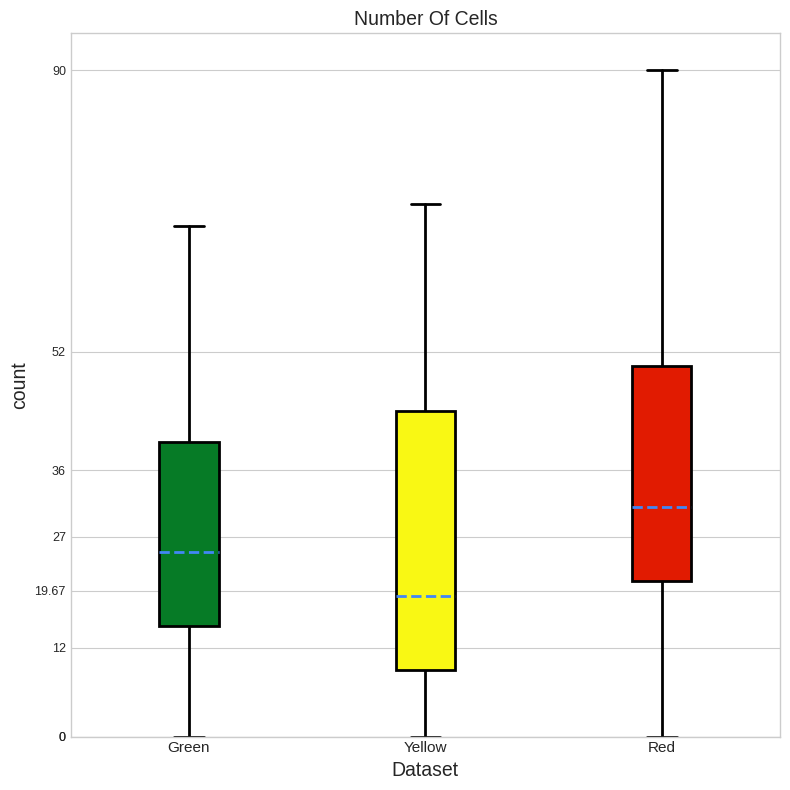

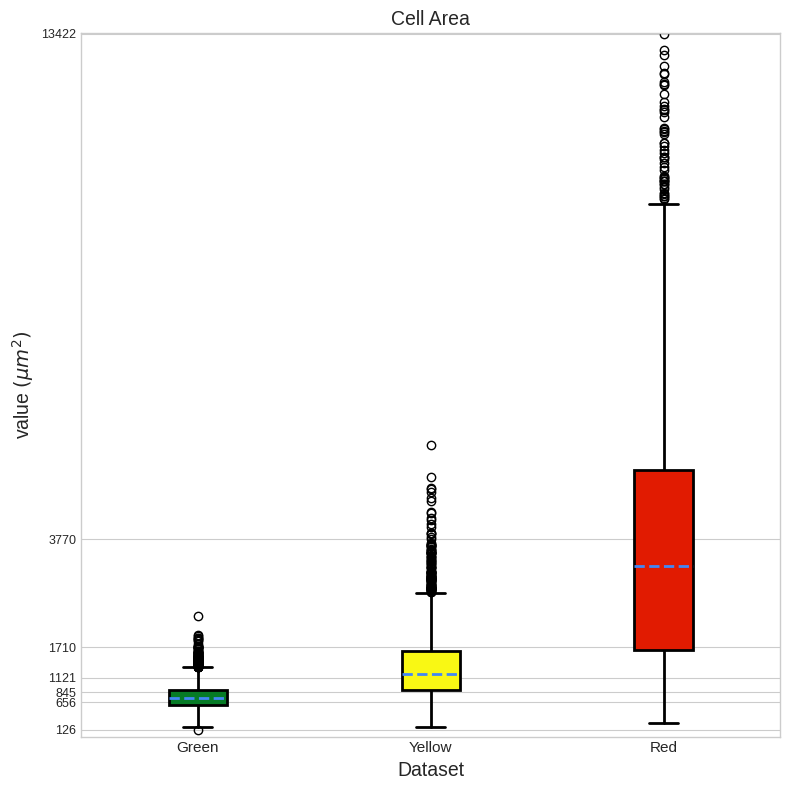

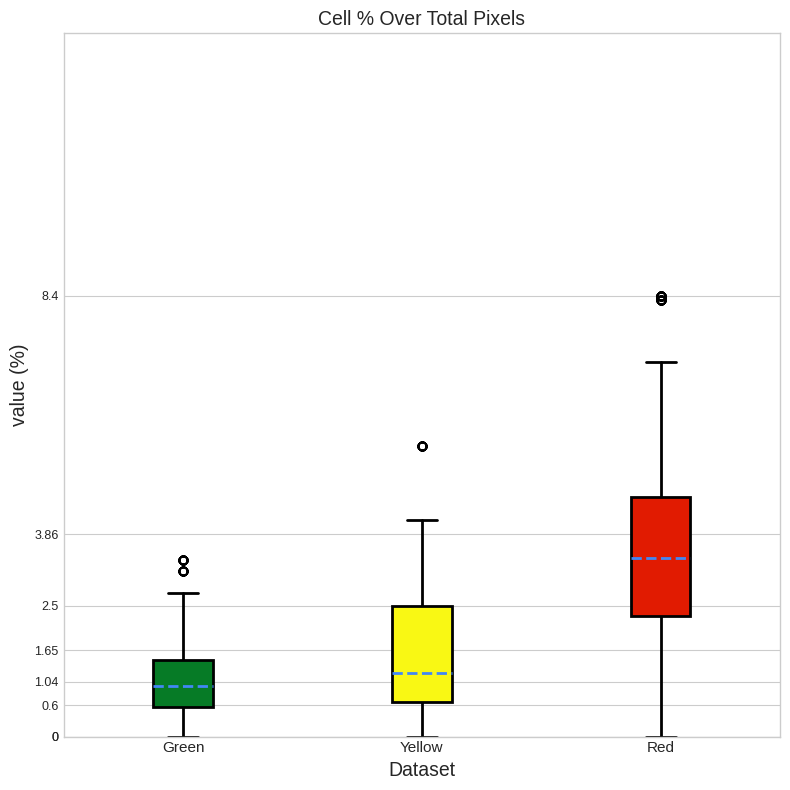

In [27]:
FIGURES_PATH = REPO_PATH / "figures"
columns_to_plot = ['n_cells', 'area', 'class1_to_total']
# columns_to_plot = ['area']

# size = 14
# params = {'legend.fontsize': 'large',
# #           'font.family': "Helvetica",
#           'figure.figsize': (8, 8),
#           'axes.labelsize': size,
#           'axes.titlesize': size,
#           'xtick.labelsize': size*0.7,
#           'ytick.labelsize': size*0.7,
#           # 'axes.titlepad': 25
#           }
# plt.rcParams.update(params)


for feature in columns_to_plot:
    if feature=="area":
        relevant_raw_stats = raw_stats.loc[~raw_stats[feature].isna(), ["dataset", feature]]
    else:
        relevant_raw_stats = raw_stats.copy()
        
    boxplot_data = [
        relevant_raw_stats[relevant_raw_stats['dataset'] == 'green'][feature],
        relevant_raw_stats[relevant_raw_stats['dataset'] == 'yellow'][feature],
        relevant_raw_stats[relevant_raw_stats['dataset'] == 'red'][feature]
    ]

    fig = plot_boxplot(boxplot_data, colors, np.array(qq))
    _ = plt.savefig(FIGURES_PATH / f"{feature}_boxplots.pdf",
                    format='pdf',
                    bbox_inches='tight',
                    pad_inches=0)
    

# Challenges

In [28]:
from fluocells.utils.annotations import load_VIA_annotations, _convert_from_VIA_polygon

CHALLENGES_PATH = REPO_PATH / "figures/challenges"
challenges_df = load_VIA_annotations(CHALLENGES_PATH / "challenges.csv")
challenges_df

filename  file_size file_attributes  region_count  region_id  \
0   1096.png    1743307              {}             6          0   
1   1096.png    1743307              {}             6          1   
2   1096.png    1743307              {}             6          2   
3   1096.png    1743307              {}             6          3   
4   1096.png    1743307              {}             6          4   
..       ...        ...             ...           ...        ...   
29   309.png     588763              {}             5          0   
30   309.png     588763              {}             5          1   
31   309.png     588763              {}             5          2   
32   309.png     588763              {}             5          3   
33   309.png     588763              {}             5          4   

                              region_shape_attributes  \
0   {'name': 'polygon', 'all_points_x': [879, 900,...   
1   {'name': 'polygon', 'all_points_x': [960, 984,...   
2   {'name': 'polygon', 'all_points_x': [341, 378,...   
3   {'name': 'polygon', 'all_points_x': [473, 511,...   
4   {'name': 'polygon', 'all_points_x': [165, 207,...   
..                                                ...   
29  {'name': 'polygon', 'all_points_x': [346, 392,...   
30  {'name': 'polygon', 'all_points_x': [236, 135,...   
31  {'name': 'polygon', 'all_points_x': [1048, 105...   
32  {'name': 'polygon', 'all_points_x': [385, 356,...   
33  {'name': 'polygon', 'all_points_x': [270, 291,...   

                   region_attributes  
0      {'challenge': 'overcrowding'}  
1      {'challenge': 'overcrowding'}  
2       {'challenge': 'marked cell'}  
3       {'challenge': 'marked cell'}  
4   {'challenge': 'non-marked cell'}  
..                               ...  
29     {'challenge': 'overcrowding'}  
30           {'challenge': 'stripe'}  
31         {'challenge': 'artifact'}  
32      {'challenge': 'marked cell'}  
33  {'challenge': 'non-marked cell'}  

[34 rows x 7 columns]

## Wide

In [29]:
# color_text = ["#02c4cb", "#c6aa0e"]
# # palette = ["#00FF00", "#faf9f9", "#28afb0", "#f4d35e", "#F73CF9",
# #            "#F74142"]  #0000F5
# # palette = ["f2d5f8","e07a5f","3d405b","81b29a","f2cc8f","e6c0e9"]
# palette = ["#00FF00", "#f4d35e", "#f2d5f8", "#C977CF", "#1461f0", "#F74142"]
# categories = [
#     'stripe', 'artifact', 'marked cell', 'non-marked cell', 'filament',
#     'overcrowding'
# ]
# palette_dict = {cat: c for cat, c in zip(categories, palette)}

# size = 18
# params = {
#     'legend.fontsize': 'large',
#     #           'font.family': "Helvetica",
#     'figure.figsize': (8, 8),
#     'axes.labelsize': size,
#     'axes.titlesize': size,
#     'xtick.labelsize': size * 0.9,
#     'ytick.labelsize': size * 0.9,
#     # 'axes.titlepad': 25
# }
# plt.rcParams.update(params)

# text_annotations = {
#     "1096.png": {
#         "labels": [
#             "overcrowding", "marked cell", "marked cell", "non-marked cell",
#             "non-marked cell"
#         ],
#         "coordinates": [[900, 580], [300, 520], [440, 940], [1400, 230],
#                         [140, 990]]
#     },
#     "1025.png": {
#         "labels": ["stripe", "filaments"],
#         "coordinates": [[1400, 200], [1300, 560]]
#     },
#     "905.png": {
#         "labels": ["dot-artifacts", "fluorophore\naccumulation"],
#         "coordinates": [[1240, 530], [800, 700]]
#     },
#     "311.png": {
#         "labels": [
#             "overcrowding", "marked cell", "non-marked cell", "filament",
#             "dot-artifact"
#         ],
#         "coordinates": [[800, 900], [1700, 460], [1450, 670], [1800, 1280],
#                         [1900, 50]]
#     },
#     "128.png": {
#         "labels": ["fluorophore\naccumulation"],
#         "coordinates": [[900, 970]]
#     },
#     "177.png": {
#         "labels": [
#             "overcrowding", "marked cell", "marked cell", "non-marked cell",
#             "non-marked cell", "stripe", "dot-artifact", "dot-artifact"
#         ],
#         "coordinates": [[700, 600], [900, 520], [1150, 970], [1100, 750],
#                         [1450, 770], [170, 420], [410, 900], [1550, 450]]
#     },
#     "309.png": {
#         "labels": [
#             "overcrowding", "stripe", "marked cell", "non-marked cell",
#             "fluorophore\naccumulation"
#         ],
#         "coordinates": [[300, 500], [100, 700], [450, 930], [380, 1070],
#                         [1000, 400]]
#     },
# }

In [30]:
# from matplotlib.patches import Polygon


# def get_y_coords(y, img_height, label):
#     y = np.array(y)

#     if "stripe" in label:
#         return y.mean() + 30
#     if "non-marked" in label:
#         return y.max() + 40

#     r = y.max() - y.min()
#     if r > img_height / 3:  #200:
#         return img_height / 12 * 7.3  #379# y.mean()
#     else:
#         return y.min()


# MULTIPLE = 20


# def get_unit_scale_line(resolution, multiple):
#     L = np.ceil(resolution * multiple)

#     x_hook, y_hook = 100, 100
#     y_bar_midlength = L / 20

#     x = [
#         x_hook, x_hook + L, None, x_hook, x_hook, None, x_hook + L, x_hook + L
#     ]
#     y = [
#         y_hook, y_hook, None, y_hook - y_bar_midlength,
#         y_hook + y_bar_midlength, None, y_hook - y_bar_midlength,
#         y_hook + y_bar_midlength
#     ]
#     x_center, y_center = x_hook + int(L / 2), y_hook

#     return x, y, x_center, y_center


# transparency = 0.2
# unit_scale_color = '#EEF0F2'  # cultured
# unit_scale_color = '#FBFBFF'  # ghost white
# unit_scale_color = '#E5E5E5'  # platinum
# y_offset = 30

# for image_name in challenges_df.filename.unique():
#     resolution = 3.991 if image_name == "311.png" else 3.187
#     unit_scale_x, unit_scale_y, unit_scale_xcenter, unit_scale_ycenter = get_unit_scale_line(
#         resolution, MULTIPLE)

#     image = io.imread(CHALLENGES_PATH / image_name)
#     img_height, img_width, _ = image.shape

#     # Create a figure and axis
#     fig, ax = plt.subplots(figsize=(16, 12))

#     # Display the image
#     _ = ax.imshow(image, origin='upper')

#     annotations = challenges_df.query(
#         "filename==@image_name")["region_shape_attributes"]
#     challenge_types = challenges_df.query(
#         "filename==@image_name")["region_attributes"]

#     for i, annotation_tuple in enumerate(zip(annotations, challenge_types)):
#         annotation, challenge_type = annotation_tuple
#         label = challenge_type["challenge"]
#         c = palette_dict[label]  # deal with dotted VS shaded examples

#         coordinates = _convert_from_VIA_polygon(annotation["all_points_x"],
#                                                 annotation["all_points_y"])
#         x, y = zip(*coordinates)
#         x = list(x)
#         x.append(x[0])
#         y = list(y)
#         y.append(y[0])
#         polygon = Polygon(
#             coordinates,
#             linewidth=3,
#             edgecolor=c,
#             facecolor=c,
#             alpha=transparency,
#         )
#         _ = ax.add_patch(polygon)

#         # Add markers on polygon's coordinates
#         _ = ax.plot(x, y, marker='o', color=c, markersize=4)

#         # Add text
#         text = text_annotations[image_name]
#         text_labels = text["labels"]
#         text_coordinates = text["coordinates"]
#         for text_label, text_coords in zip(text_labels, text_coordinates):
#             xanch = 'right' if text_label in ['filament', 'dot-artifact'
#                                               ] else 'center'
#             yanch = 'top' if 'non-marked' in text_label else 'center'
#             _ = ax.text(text_coords[0],
#                         text_coords[1],
#                         text_label,
#                         color=color_text[0],
#                         fontsize=params['axes.labelsize'],
#                         ha=xanch,
#                         va=yanch)

#         # Add unit scale
#         _ = ax.plot(unit_scale_x,
#                     unit_scale_y,
#                     color=unit_scale_color,
#                     markersize=1)
#         _ = ax.text(unit_scale_xcenter,
#                     unit_scale_ycenter - y_offset / 2,
#                     f"{MULTIPLE} µm",
#                     color=unit_scale_color,
#                     fontsize=int(size * 2 / 3),
#                     ha='center')

#         # Remove the axis ticks
#         _ = ax.set_xticks([])
#         _ = ax.set_yticks([])

#     _ = plt.savefig(CHALLENGES_PATH / f"{image_name.split('.')[0]}.pdf",
#                     format='pdf',
#                     bbox_inches='tight',
#                     pad_inches=0)
#     _ = plt.show()

## Small

In [31]:
color_text = ["#02c4cb", "#c6aa0e"]
# palette = ["#00FF00", "#faf9f9", "#28afb0", "#f4d35e", "#F73CF9",
#            "#F74142"]  #0000F5
# palette = ["f2d5f8","e07a5f","3d405b","81b29a","f2cc8f","e6c0e9"]
palette = ["#00FF00", "#f4d35e", "#f2d5f8", "#C977CF", "#1461f0", "#F74142"]
categories = [
    'stripe', 'artifact', 'marked cell', 'non-marked cell', 'filament',
    'overcrowding'
]
palette_dict = {cat: c for cat, c in zip(categories, palette)}

size = 18
params = {
    'legend.fontsize': 'large',
    #           'font.family': "Helvetica",
    'figure.figsize': (8, 8),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.9,
    'ytick.labelsize': size * 0.9,
    # 'axes.titlepad': 25
}
plt.rcParams.update(params)

text_annotations = {
    "1096.png": {
        "labels": [
            "overcrowding", "marked\ncell", "marked\ncell", "non-marked\ncell",
            "non-marked\ncell"
        ],
        "coordinates": [[900, 580], [300, 480], [650, 1100], [1400, 230],
                        [200, 900]]
    },
    "1025.png": {
        "labels": ["stripe", "filaments"],
        "coordinates": [[1400, 200], [1200, 560]]
    },
    "905.png": {
        "labels": ["dot-artifacts", "fluorophore\naccumulation"],
        "coordinates": [[1240, 350], [800, 650]]
    },
    "311.png": {
        "labels": [
            "overcrowding", "marked\ncell", "non-marked\ncell", "filament",
            "dot-artifact"
        ],
        "coordinates": [[600, 900], [1800, 460], [1150, 500], [1800, 1280],
                        [1900, 50]]
    },
    "128.png": {
        "labels": ["fluorophore\naccumulation"],
        "coordinates": [[900, 920]]
    },
    "177.png": {
        "labels": [
            "overcrowding", "marked\ncell", "marked\ncell", "non-marked\ncell",
            "non-marked\ncell", "stripe", "dot-artifact", "dot-artifact"
        ],
        "coordinates": [[570, 550], [1000, 400], [1050, 1060], [1150, 700],
                        [1400, 970], [200, 420], [610, 1050], [1550, 450]]
    },
    "309.png": {
        "labels": [
            "overcrowding", "stripe", "marked\ncell", "non-marked\ncell",
            "fluorophore\naccumulation"
        ],
        "coordinates": [[400, 480], [80, 700], [590, 880], [520, 1060],
                        [1000, 350]]
    },
}

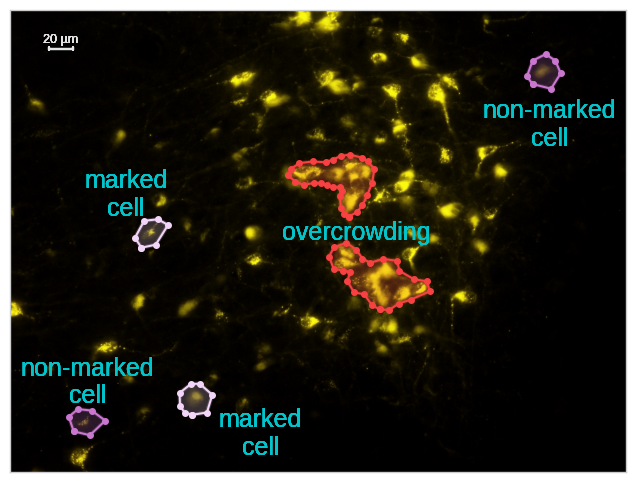

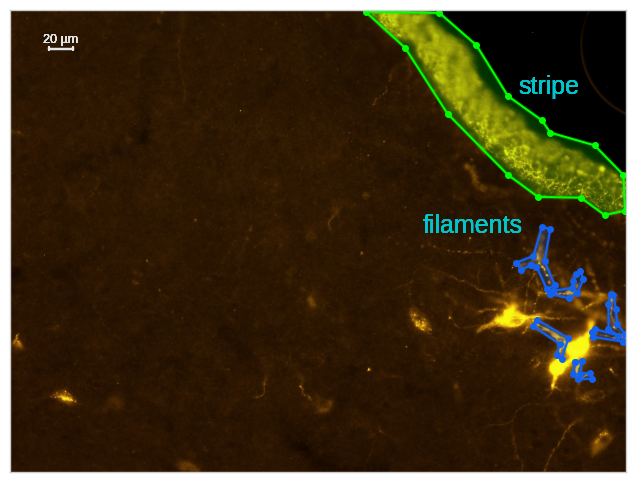

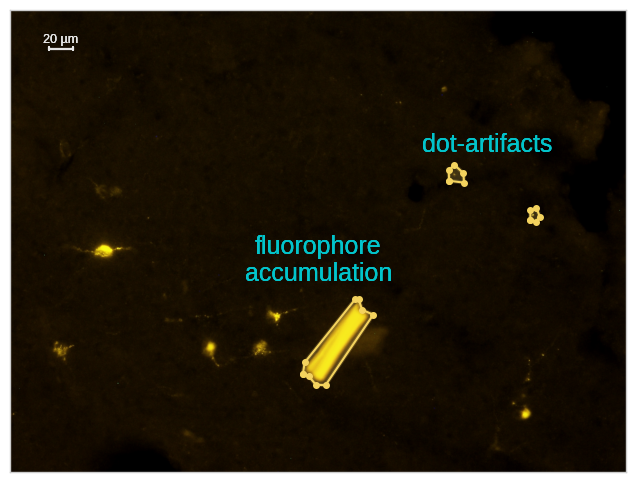

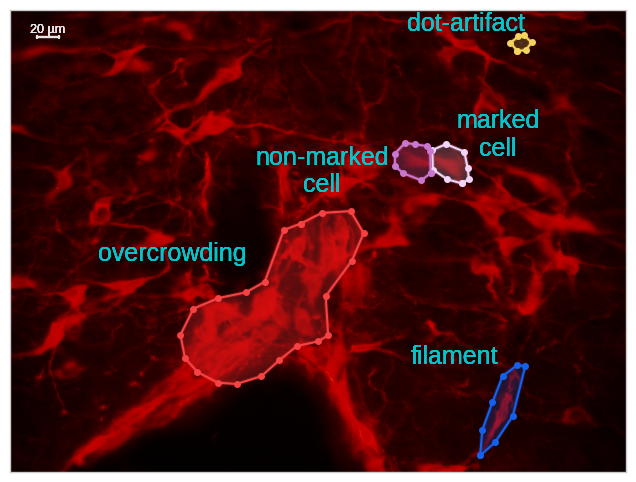

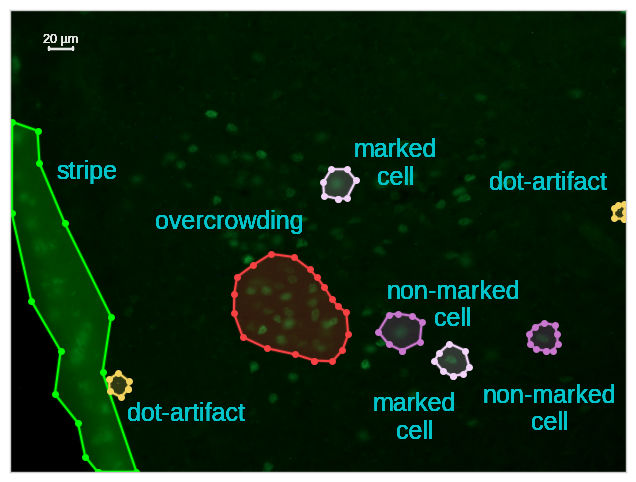

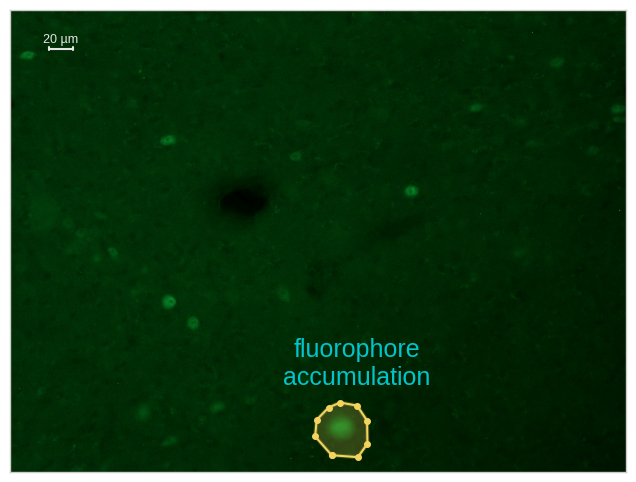

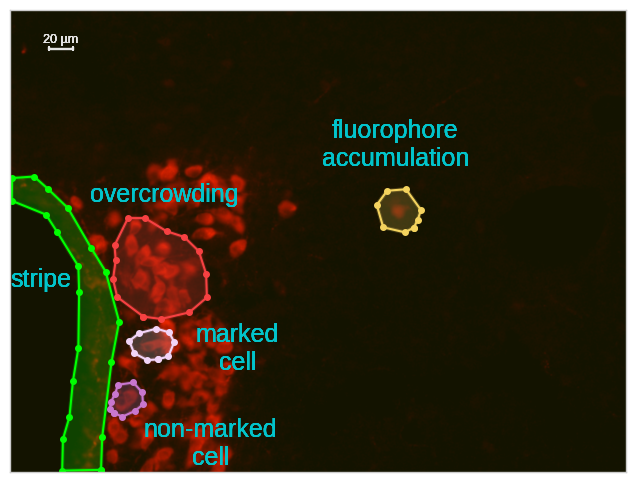

In [32]:
from matplotlib.patches import Polygon


def get_y_coords(y, img_height, label):
    y = np.array(y)

    if "stripe" in label:
        return y.mean() + 30
    if "non-marked" in label:
        return y.max() + 40

    r = y.max() - y.min()
    if r > img_height / 3:  #200:
        return img_height / 12 * 7.3  #379# y.mean()
    else:
        return y.min()


MULTIPLE = 20


def get_unit_scale_line(resolution, multiple):
    L = np.ceil(resolution * multiple)

    x_hook, y_hook = 100, 100
    y_bar_midlength = L / 20

    x = [
        x_hook, x_hook + L, None, x_hook, x_hook, None, x_hook + L, x_hook + L
    ]
    y = [
        y_hook, y_hook, None, y_hook - y_bar_midlength,
        y_hook + y_bar_midlength, None, y_hook - y_bar_midlength,
        y_hook + y_bar_midlength
    ]
    x_center, y_center = x_hook + int(L / 2), y_hook

    return x, y, x_center, y_center


transparency = 0.2
unit_scale_color = '#EEF0F2'  # cultured
unit_scale_color = '#FBFBFF'  # ghost white
unit_scale_color = '#E5E5E5'  # platinum
y_offset = 30

for image_name in challenges_df.filename.unique():
    resolution = 3.991 if image_name == "311.png" else 3.187
    unit_scale_x, unit_scale_y, unit_scale_xcenter, unit_scale_ycenter = get_unit_scale_line(
        resolution, MULTIPLE)

    image = io.imread(CHALLENGES_PATH / image_name)
    img_height, img_width, _ = image.shape

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Display the image
    _ = ax.imshow(image, origin='upper')

    annotations = challenges_df.query(
        "filename==@image_name")["region_shape_attributes"]
    challenge_types = challenges_df.query(
        "filename==@image_name")["region_attributes"]

    for i, annotation_tuple in enumerate(zip(annotations, challenge_types)):
        annotation, challenge_type = annotation_tuple
        label = challenge_type["challenge"]
        c = palette_dict[label]  # deal with dotted VS shaded examples

        coordinates = _convert_from_VIA_polygon(annotation["all_points_x"],
                                                annotation["all_points_y"])
        x, y = zip(*coordinates)
        x = list(x)
        x.append(x[0])
        y = list(y)
        y.append(y[0])
        polygon = Polygon(
            coordinates,
            linewidth=3,
            edgecolor=c,
            facecolor=c,
            alpha=transparency,
        )
        _ = ax.add_patch(polygon)

        # Add markers on polygon's coordinates
        _ = ax.plot(x, y, marker='o', color=c, markersize=4)

        # Add text
        text = text_annotations[image_name]
        text_labels = text["labels"]
        text_coordinates = text["coordinates"]
        for text_label, text_coords in zip(text_labels, text_coordinates):
            xanch = 'right' if text_label in ['filament', 'dot-artifact'
                                              ] else 'center'
            yanch = 'top' if 'non-marked' in text_label else 'center'
            _ = ax.text(text_coords[0],
                        text_coords[1],
                        text_label,
                        color=color_text[0],
                        fontsize=params['axes.labelsize'],
                        ha=xanch,
                        va=yanch)

        # Add unit scale
        _ = ax.plot(unit_scale_x,
                    unit_scale_y,
                    color=unit_scale_color,
                    markersize=1)
        _ = ax.text(unit_scale_xcenter,
                    unit_scale_ycenter - y_offset / 2,
                    f"{MULTIPLE} µm",
                    color=unit_scale_color,
                    fontsize=9,
                    ha='center')

        # Remove the axis ticks
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])

    _ = plt.savefig(CHALLENGES_PATH / f"{image_name.split('.')[0]}.pdf",
                    format='pdf',
                    bbox_inches='tight',
                    pad_inches=0)
    _ = plt.show()

# Technical validation

In [33]:
TECHNICAL_VALIDATION_PATH = REPO_PATH / "figures/technical_validation"
technical_validation_df = load_VIA_annotations(TECHNICAL_VALIDATION_PATH / "validation.csv")
technical_validation_df

filename  file_size file_attributes  region_count  \
0                         1147.png       2947              {}             4   
1                         1147.png       2947              {}             4   
2                         1147.png       2947              {}             4   
3                         1147.png       2947              {}             4   
4   Mar19bS1C4R1_VLPAGl_200x_y.png       6098              {}             4   
5   Mar19bS1C4R1_VLPAGl_200x_y.png       6098              {}             4   
6   Mar19bS1C4R1_VLPAGl_200x_y.png       6098              {}             4   
7   Mar19bS1C4R1_VLPAGl_200x_y.png       6098              {}             4   
8                          925.png       6032              {}             5   
9                          925.png       6032              {}             5   
10                         925.png       6032              {}             5   
11                         925.png       6032              {}             5   
12                         925.png       6032              {}             5   
13     Mar19bS1C5R2_LHl_200x_y.png       7675              {}             5   
14     Mar19bS1C5R2_LHl_200x_y.png       7675              {}             5   
15     Mar19bS1C5R2_LHl_200x_y.png       7675              {}             5   
16     Mar19bS1C5R2_LHl_200x_y.png       7675              {}             5   
17     Mar19bS1C5R2_LHl_200x_y.png       7675              {}             5   

    region_id                            region_shape_attributes  \
0           0  {'name': 'ellipse', 'cx': 480, 'cy': 513, 'rx'...   
1           1  {'name': 'rect', 'x': 106, 'y': 982, 'width': ...   
2           2   {'name': 'circle', 'cx': 542, 'cy': 97, 'r': 18}   
3           3  {'name': 'circle', 'cx': 334, 'cy': 140, 'r': 13}   
4           0  {'name': 'circle', 'cx': 334, 'cy': 140, 'r': 13}   
5           1   {'name': 'circle', 'cx': 542, 'cy': 97, 'r': 18}   
6           2  {'name': 'rect', 'x': 106, 'y': 982, 'width': ...   
7           3  {'name': 'ellipse', 'cx': 480, 'cy': 513, 'rx'...   
8           0  {'name': 'polygon', 'all_points_x': [176, 145,...   
9           1  {'name': 'polygon', 'all_points_x': [67, 30, 6...   
10          2  {'name': 'polygon', 'all_points_x': [870, 999,...   
11          3  {'name': 'polygon', 'all_points_x': [1459, 141...   
12          4  {'name': 'polygon', 'all_points_x': [450, 486,...   
13          0  {'name': 'polygon', 'all_points_x': [67, 30, 6...   
14          1  {'name': 'polygon', 'all_points_x': [870, 999,...   
15          2  {'name': 'polygon', 'all_points_x': [450, 486,...   
16          3  {'name': 'polygon', 'all_points_x': [176, 145,...   
17          4  {'name': 'polygon', 'all_points_x': [1459, 141...   

   region_attributes  
0                 {}  
1                 {}  
2                 {}  
3                 {}  
4                 {}  
5                 {}  
6                 {}  
7                 {}  
8                 {}  
9                 {}  
10                {}  
11                {}  
12                {}  
13                {}  
14                {}  
15                {}  
16                {}  
17                {}

In [34]:
color_text = ["#02c4cb", "#c6aa0e"]
categories = ["rect", "ellipse", "circle", "polygon"]
palette = ["#0696FD", "#FFBC42", "#00FF00", "#e07a5f"]
palette_dict = {cat: c for cat, c in zip(categories, palette)}

size = 18
params = {
    'legend.fontsize': 'large',
    #           'font.family': "Helvetica",
    'figure.figsize': (8, 8),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.9,
    'ytick.labelsize': size * 0.9,
    # 'axes.titlepad': 25
}
plt.rcParams.update(params)

text_annotations = {
    "rect": {
        "labels": ["fill\nholes"],
        "coordinates": [[300, 1000]]
    },
    "ellipse": {
        "labels": ["smooth\ncontours"],
        "coordinates": [[700, 550]]
    },
    "circle": {
        "labels": ["remove\nsmall objects"],
        "coordinates": [[650, 260],]
    },
    "polygon": {
        "labels": ["review\nannotations"],
        "coordinates": [[700, 1100],]
    },
}

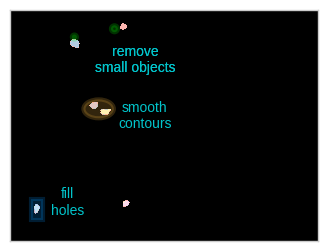

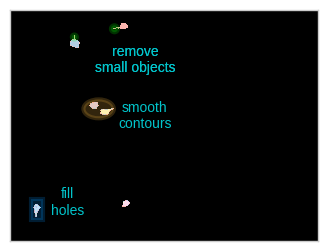

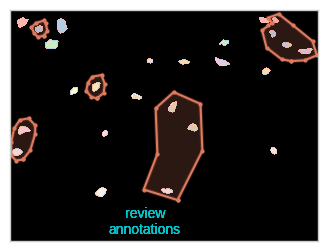

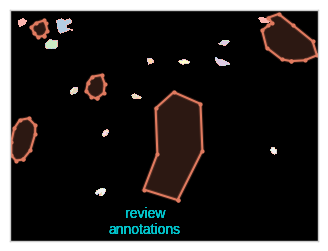

In [35]:
from matplotlib.patches import Polygon
import matplotlib.patches as patches
from skimage import measure
import matplotlib.colors as mcolors


def generate_pastel_colormap(length):
    # Creating pastel colors
    # Lowering the saturation of colors to get a pastel feel
    pastel_colors = plt.cm.Pastel1(np.linspace(0, 1, length))

    # Insert black color at the start
    pastel_colors = np.vstack(([0, 0, 0, 1], pastel_colors))  

    # Create new colormap
    pastel_cmap = mcolors.ListedColormap(pastel_colors)

    return pastel_cmap

    

for image_name in technical_validation_df.filename.unique():

    image = io.imread(TECHNICAL_VALIDATION_PATH / image_name, as_gray=True)
    img_height, img_width = image.shape
    
    objects_colormap = generate_pastel_colormap(measure.label(image, return_num=True)[1])
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4, 3))
    _ = ax.imshow(measure.label(image), cmap=objects_colormap, origin='upper')

    annotations = technical_validation_df.query(
        "filename==@image_name")["region_shape_attributes"]

    for i, annotation in enumerate(annotations):
        validation_type = annotation["name"]
        text = text_annotations[validation_type]
        c = palette_dict[validation_type]

        # Define the center, radius, and color of the circle
        if validation_type=='circle':
            center = annotation["cx"], annotation["cy"]  # center coordinates (y, x)
            radius = annotation["r"]  # radius

            # Create the Circle patch
            circle = patches.Circle(center, radius, edgecolor=c, facecolor=c, fill=True, linewidth=3, alpha=transparency)
            _ = ax.add_patch(circle)
        elif validation_type == "ellipse":
            # Define the center, width, height, angle, and color of the ellipse
            center = annotation["cx"] - 20, annotation["cy"]  # center coordinates (y, x)
            width = annotation["rx"] + 60  # width
            height = annotation["ry"] + 30  # height
            angle = annotation["theta"]  # angle (in degrees)

            # Create the Ellipse patch
            ellipse = patches.Ellipse(center, width, height, angle=angle, edgecolor=c, facecolor=c, fill=True, linewidth=3, alpha=transparency)
            _ = ax.add_patch(ellipse)
        elif validation_type=="rect":
            # Define the center, width, height, angle, and color of the ellipse
            origin = annotation["x"], annotation["y"]  # center coordinates (y, x)
            width = annotation["width"]  # width
            height = annotation["height"]  # height

            # Create the Rectangle patch
            rectangle = patches.Rectangle(origin, width, height, edgecolor=c, facecolor=c, linewidth=3, alpha=transparency)
            _ = ax.add_patch(rectangle)
        else: # "polygon"
            coordinates = _convert_from_VIA_polygon(annotation["all_points_x"],
                                                annotation["all_points_y"])
            x, y = zip(*coordinates)
            x = list(x)
            x.append(x[0])
            y = list(y)
            y.append(y[0])
            polygon = Polygon(
                coordinates,
                linewidth=3,
                edgecolor=c,
                facecolor=c,
                alpha=transparency,
            )
            _ = ax.add_patch(polygon)

            # Add markers on polygon's coordinates
            _ = ax.plot(x, y, marker='o', color=c, markersize=2)
            
            
        # Add text
        text_labels = text["labels"]
        text_coordinates = text["coordinates"]
        for text_label, text_coords in zip(text_labels, text_coordinates):
            xanch = 'right' if text_label in ['filament', 'dot-artifact'
                                              ] else 'center'
            yanch = 'top' if 'non-marked' in text_label else 'center'
            _ = ax.text(text_coords[0],
                        text_coords[1],
                        text_label,
                        color=color_text[0],
                        fontsize=10,#params['axes.labelsize'],
                        ha=xanch,
                        va=yanch)

        # Remove the axis ticks
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])    
    
    _ = plt.savefig(TECHNICAL_VALIDATION_PATH / f"{image_name.split('.')[0]}.pdf",
                    format='pdf',
                    bbox_inches='tight',
                    pad_inches=0)    